In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import time
from googleapiclient import discovery
from googletrans import Translator  
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from emfdscore.scoring import score_docs 
from cleantext import clean
import re
import string
bridge_file = open('./Bridge.txt','r')
key_list = bridge_file.readlines()
YT_API_KEY = key_list[0]
PERS_API_KEY = key_list[1]
bridge_file.close()

In [45]:
translator = Translator()

In [61]:
def get_video_category_stats(video_id_list,input_dataset,column_name,thresh):
    video_cat_pos_stats = {}
    vc_pos_stats_dist = {}
    video_cat_neg_stats = {}
    vc_neg_stats_dist = {}
    total_vids = 0
    for idx in input_dataset.index:
        if input_dataset[column_name][idx] > thresh:
            video_ind = video_id_list.index(input_dataset['videoIds'][idx])
            if yt_data['videoCategory'][video_ind] != 'NA':
                if yt_data['videoCategory'][video_ind] in video_cat_pos_stats:
                    video_cat_pos_stats[yt_data['videoCategory'][video_ind]] = video_cat_pos_stats[yt_data['videoCategory'][video_ind]] + 1
                else:
                    video_cat_pos_stats[yt_data['videoCategory'][video_ind]] = 1
                total_vids = total_vids+1
        elif  input_dataset[column_name][idx] < thresh:
            video_ind = video_id_list.index(input_dataset['videoIds'][idx])
            if yt_data['videoCategory'][video_ind] != 'NA':
                if yt_data['videoCategory'][video_ind] in video_cat_neg_stats:
                    video_cat_neg_stats[yt_data['videoCategory'][video_ind]] = video_cat_neg_stats[yt_data['videoCategory'][video_ind]] + 1
                else:
                    video_cat_neg_stats[yt_data['videoCategory'][video_ind]] = 1
                total_vids = total_vids+1
    for video_cat in video_cat_pos_stats:
        vc_pos_stats_dist[video_cat] = round((video_cat_pos_stats[video_cat]/total_vids)*100,2)
    for video_cat in video_cat_neg_stats:
        vc_neg_stats_dist[video_cat] = round((video_cat_neg_stats[video_cat]/total_vids)*100,2)
    return video_cat_pos_stats,vc_pos_stats_dist,video_cat_neg_stats,vc_neg_stats_dist

In [46]:
def get_week_dictionary(date_list, date_week, input_dataset, column_name,perc_flag):
    total_ents = 0
    wmy_dict_dist = {}
    for date_pub in input_dataset[column_name]:
        if date_pub != 'NA':
            pub_year,pub_month,pub_day = get_year_from_str(date_pub)
            date_str = f'{pub_year}-{pub_month}'
            if date_str in date_list:
                if pub_day <= 7:
                    date_week[date_str+'-07'] = date_week[date_str+'-07']+1
                elif pub_day <= 15:
                    date_week[date_str+'-15'] = date_week[date_str+'-15']+1
                elif pub_day <= 23:
                    date_week[date_str+'-23'] = date_week[date_str+'-23']+1
                else:
                    date_week[date_str+'-31'] = date_week[date_str+'-31']+1
                total_ents = total_ents+1
    if perc_flag is True:
        for date_pub in wmy_dict:
            wmy_dict_dist[date_pub] = round((date_week[date_pub]/total_ents)*100,2)
        return wmy_dict_dist
    return date_week

In [47]:
#4 weeks in 1 month, 1-7,8-15,16-23,24-31
wmy_dict = {}
def get_date_dictionary_week(min_year,min_month,max_year,max_month):
    date_range_dict = get_date_range_dictionary(min_month, min_year, max_month, max_year)
    for my in date_range_dict:
        wmy_dict[my+'-07'] = 0
        wmy_dict[my+'-15'] = 0
        wmy_dict[my+'-23'] = 0
        wmy_dict[my+'-31'] = 0
    return wmy_dict
#print(wmy_dict)

In [48]:
client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=PERS_API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

In [49]:
def get_preprocessed_text(input_text):
    #convert to lower case
    input_text = input_text.lower()
    #Remove extra whitespaces
    input_text = " ".join(input_text.split())
    #Remove numbers
    input_text = re.sub(r'\d+', '', input_text)
    #Remove punctuation
    input_text = input_text.translate(str.maketrans('', '', string.punctuation))
    #Remove link/html tags
    input_text=''.join(input_text)
    html_pattern = re.compile('<.*?>')
    input_text = html_pattern.sub(r'', input_text)
    #Remove emoticons
    final_string = clean(input_text, no_emoji=True)
    #translate to english
    final_string = translator.translate(final_string).text
    #print(final_string)
    return final_string

In [50]:
def get_perspective_from(input_text):
    analyze_request = {
      'comment': { 'text': input_text },
      'requestedAttributes': {'TOXICITY': {},
              'INSULT': {},
              'THREAT': {}}
    }
    time.sleep(1.1)
    try:
        pers_response = client.comments().analyze(body=analyze_request).execute()
        #print(pers_response)
        INSULT_VAL = pers_response['attributeScores']['INSULT']['spanScores'][0]['score']['value']
        TOXIC_VAL = pers_response['attributeScores']['TOXICITY']['spanScores'][0]['score']['value']
        THREAT_VAL = pers_response['attributeScores']['THREAT']['spanScores'][0]['score']['value']
    except:
        INSULT_VAL = -1
        TOXIC_VAL = -1
        THREAT_VAL = -1
        #print('Error!')
    return INSULT_VAL,TOXIC_VAL,THREAT_VAL
#print(get_perspective_from('Hey whats up?'))

In [8]:
%matplotlib qt

In [9]:
def get_date_range_dictionary(min_month, min_year, max_month, max_year):
    start_month = min_month
    start_year = min_year
    end_month = 12
    end_year = max_year
    total_instances = 0
    share_time_count = {}
    for this_year in range(start_year,end_year+1):
        if this_year != start_year:
            start_month = 1
        if this_year == end_year:
            end_month = max_month
        for this_month in range(start_month,end_month+1):
            final_time = f'{this_year}-{this_month}'
            if final_time not in share_time_count:
                share_time_count[final_time] = 0
    return share_time_count

In [10]:
def get_date_dictionary(min_month, min_year, max_month, max_year, input_dataset, column_name,percent_req):
    start_month = min_month
    start_year = min_year
    end_month = 12
    end_year = max_year
    total_instances = 0
    share_time_count = {}
    for this_year in range(start_year,end_year+1):
        if this_year != start_year:
            start_month = 1
        if this_year == end_year:
            end_month = max_month
        for this_month in range(start_month,end_month+1):
            final_time = f'{this_year}-{this_month}'
            if final_time not in share_time_count:
                share_time_count[final_time] = 0
    #print(share_time_count)
    for date_pub in input_dataset[column_name]:
        if date_pub != 'NA':
            fetch_year,fetch_month,fetch_day = get_year_from_str(date_pub)
            final_time = f'{fetch_year}-{fetch_month}'
            if final_time in share_time_count:
                share_time_count[final_time] = share_time_count[final_time]+1
            else:
                print(f'{final_time} not in dictionary')
            total_instances = total_instances+1
    if percent_req:
        for final_item in share_time_count:
            share_time_count[final_item] = round((share_time_count[final_item]/total_instances)*100,2)
    print(share_time_count)
    return share_time_count

In [11]:
def get_date_range_from(input_dataset,column_name):
    date_list = input_dataset[column_name].tolist()
    min_yr,min_mth,min_day = get_year_from_str(date_list[0])
    max_yr,max_mth = min_yr,min_mth
    year_from_str = 0
    month_from_str = 0
    for date_item in date_list:
        if date_item != 'NA':
            year_from_str,month_from_str,day_from_str = get_year_from_str(date_item)
            if year_from_str < min_yr:
                min_yr = year_from_str
                min_mth = month_from_str
            elif year_from_str == min_yr:
                if month_from_str < min_mth:
                    min_mth = month_from_str
            elif year_from_str > max_yr:
                max_yr = year_from_str
                max_mth = month_from_str
            elif year_from_str == max_yr:
                if month_from_str > max_mth:
                    max_mth = month_from_str
    print(f'Dataset ranges from {min_mth}/{min_yr} to {max_mth}/{max_yr}')
    return min_mth,min_yr,max_mth,max_yr
#print(get_date_range_from(yt_data,'videoPublishedAt'))

In [12]:
def get_video_category_from_id(categoryId):
    category_dict = {'1':'Film & Animation','2':'Autos & Vehicles','10':'Music','15':'Pets & Animals','17':'Sports','19':'Travel & Events',
'20':'Gaming','22':'People & Blogs','23':'Comedy','24':'Entertainment','25':'News & Politics','26':'Howto & Style','27':'Education',
'28':'Science & Technology','29':'Nonprofits & Activism'}
    if categoryId in category_dict:
        return category_dict[categoryId]
    else:
        print(f'{categoryId}: NA')
        return 'NA'
#print(get_video_category_from_id('3'))

In [13]:
def get_year_from_str(date_str):
    return int(date_str[0:4]),int(date_str[5:7]),int(date_str[8:10])
#get_year_from_str('2021-11-31 18:50:56')

In [14]:
#"https://en.wikipedia.org/wiki/Religion"
def get_topic_category_from_wiki(wiki_link):
    if 'en.wikipedia.org/wiki/' in wiki_link:
        topic_index = wiki_link.index('wiki/')
        return wiki_link[topic_index+5:]
    else:
        return 'NA'
#get_topic_category_from_wiki('https://en.wikipedia.org/wiki/Religion')

In [15]:
def convert_time_to_sec(time_str):
    #PT1H15M44S
    total_seconds = 0
    
    if 'DT' in time_str:
        time_str = time_str[1:]
        index = time_str.index('DT')
        day_time = int(time_str[0:index])
        total_seconds = day_time*86400
        time_str = time_str[index+2:]
    else:
        time_str = time_str[2:]
    if 'H' in time_str:
        index = time_str.index('H')
        hour_time = int(time_str[0:index])
        total_seconds = total_seconds+(hour_time*3600)
        time_str = time_str[index+1:]
        #print(hour_time)
        #print(time_str)
    if 'M' in time_str:
        index = time_str.index('M')
        min_time = int(time_str[0:index])
        total_seconds = total_seconds+(min_time*60)
        time_str = time_str[index+1:]
        #print(time_str)
        #print(min_time)
    if 'S' in time_str:
        index = time_str.index('S')
        sec_time = int(time_str[0:index])
        total_seconds = total_seconds+sec_time
        #print(sec_time)
    return total_seconds
        #print(time_str)
print(convert_time_to_sec('PT24H60M60S'))

90060


In [16]:
def removeAllSplChars(word):
    word = word.strip()
    spl_characters = ['!','#','$','%','&','(',')','*','+','-','.','/',':',';','<','=','>','?','@','[',']','_','{','}']
    for chars in spl_characters:
        word = word.replace(chars,'')
    return word

In [17]:
def plot_the_list(x_list=[0,0,0], y_list=[0,0,0], bar_color='blue',x_label='X Label', y_label='Y Label', graph_title='Graph Title', graph_width=0.5):
    fig = plt.figure(figsize = (20, 10))
    plt.bar(x_list, y_list, color=bar_color,width=graph_width)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

In [18]:
def make_a_list(sorted_entities):
    max_results = int(input('How many results you want in graph? '))
    key_list = []
    val_list = []
    if len(sorted_entities) > max_results:
        for x in range(0,max_results):
            key_list.append(sorted_entities[x][0])
            val_list.append(sorted_entities[x][1])
    else:
        for x in range(0,len(sorted_entities)):
            key_list.append(sorted_entities[x][0])
            val_list.append(sorted_entities[x][1])
    #print(key_list, val_list)
    return key_list, val_list

In [19]:
data = pd.read_csv('./dataset/yt.csv', low_memory=False)
temp_data = data

In [20]:
data

date              updated     type  \
0       2021-09-01 18:50:56  2021-10-07 23:44:11  youtube   
1       2021-09-01 18:49:19  2021-10-03 17:29:06  youtube   
2       2021-09-01 18:44:22  2022-02-07 02:20:43  youtube   
3       2021-09-01 18:43:07  2021-09-07 11:29:00  youtube   
4       2021-09-01 18:42:44  2021-09-07 10:31:58  youtube   
...                     ...                  ...      ...   
986206  2022-02-24 03:25:23  2022-03-10 19:47:35  youtube   
986207  2022-02-24 03:25:21  2022-03-10 23:02:18    video   
986208  2022-02-24 03:25:11  2022-02-28 13:44:36  youtube   
986209  2022-02-24 03:24:48  2022-03-11 09:09:34  youtube   
986210  2022-02-24 03:24:45  2022-02-26 17:52:49  youtube   

                                              description  \
0       "Буковина" припиняє боротьбу у Кубку України. ...   
1       Зустріч у США президентів Джо Байдена і Володи...   
2       #"Говорить! Не надо бояться!" «Платформа» Андр...   
3       Сьогодні в гостях у @СЕРГІЙ ЛЕЩЕНКО Валерій Ча...   
4       БЕСПРЕДЕЛ! Зеленский оф*гел! Социальный взрыв ...   
...                                                   ...   
986206  #игрянулгрэм #обращениепутина #днр #лнр #украи...   
986207  МОНСТРЫ ОКУНЯ В КИЕВЕ | Подводная Охота | П.О ...   
986208  Красномовні заяви про зад Путіна і нова хвиля ...   
986209  Ukraine President Volodymyr Zelenskyy (Puppet ...   
986210  Красномовні заяви про зад Путіна і нова хвиля ...   

                                                  message  \
0       Драма у матчі БУКОВИНА - ПРИКАРПАТТЯ / пенальт...   
1                                                     NaN   
2                                       Смешно и серьезно   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
986206                                             Война?   
986207  Время летит как вода: работа, дом, семейный бы...   
986208                                                NaN   
986209                                                NaN   
986210                                                NaN   

                                            expandedLinks  \
0       [{'original': 'https://youtu.be/IJeEczs3cVY', ...   
1       [{'original': 'https://youtube.com/watch?v=I1H...   
2       [{'original': 'https://platforma-karaulov.ru/'...   
3       [{'original': 'https://youtube.com/watch?v=ndg...   
4       [{'original': 'https://t.me/politman_ua', 'exp...   
...                                                   ...   
986206  [{'original': 'https://youtube.com/watch?v=oAT...   
986207  [{'original': 'https://youtu.be/5G_QI6iUS9Q', ...   
986208  [{'original': 'https://www.youtube.com/watch?v...   
986209  [{'original': 'https://youtube.com/watch?v=eR3...   
986210  [{'original': 'https://www.youtube.com/watch?v...   

                                                     link  \
0                            https://youtu.be/IJeEczs3cVY   
1       https://youtube.com/watch?v=I1HSUGKLH0E&featur...   
2             https://www.youtube.com/watch?v=fzVS23qZa2c   
3       https://youtube.com/watch?v=ndgMddeuT1M&featur...   
4       https://youtube.com/watch?v=sQJP8aoTo50&featur...   
...                                                   ...   
986206  https://youtube.com/watch?v=oATvY1smXf8&featur...   
986207                       https://youtu.be/5G_QI6iUS9Q   
986208        https://www.youtube.com/watch?v=Im2s8uf76hc   
986209  https://youtube.com/watch?v=eR3UCOVGb_I&featur...   
986210        https://www.youtube.com/watch?v=Im2s8uf76hc   

                                                  postUrl  subscriberCount  \
0       https://www.facebook.com/749375571844814/posts...           4019.0   
1       https://www.facebook.com/groups/48597114874267...           1405.0   
2       https://www.facebook.com/groups/10703492163725...           8347.0   
3       https://www.facebook.com/groups/229033

In [ ]:
data.describe()

In [ ]:
data.columns

In [ ]:
data.nunique()

In [ ]:
data['pageAdminTopCountry'].unique()

In [ ]:
data['accountType'].unique()

In [ ]:
data.isnull().sum()

In [6]:
data.shape

(986211, 32)

In [ ]:
v_count = 0
amp_count = 0
for link in  data['link']:
    #v_ind = link.indexOf('v=')
    #amp_ind = link.indexOf('&')
    if 'v=' in link:
        v_count = v_count+1
    if '&' in link:
        amp_count = amp_count+1
        print(link)
print(v_count, amp_count, data.shape[0])

In [25]:
#Retrieving video ids

In [ ]:
data = temp_data
print(temp_data)

In [24]:
videoIds = []
str = ""
for link in data['link']:
    if 'youtube.com' in link:
        v_index = link.find('v=')
        amp_index = link.find('&')
        if v_index != -1:
            if amp_index != -1:
                stri = link[v_index+2:amp_index]
                if len(stri) == 11:
                    videoIds.append(stri)
                else:
                    videoIds.append('NA')
            else:
                stri = link[v_index+2:v_index+13]
                if len(stri) == 11:
                    videoIds.append(stri)
                else:
                    videoIds.append('NA')
        else:
            videoIds.append('NA')
    elif 'youtu.be' in link:
        be_index = link.find('.be/')
        if be_index != -1 and be_index+4 < len(link):
            stri = link[be_index+4:be_index+15]
            #print(stri)
            if len(stri) == 11:
                videoIds.append(stri)
            else:
                videoIds.append('NA')
        else:
            videoIds.append('NA')
    else:
        videoIds.append('NA')

data.insert(1, "videoIds",videoIds)
#yt_data = pd.DataFrame(videoIds, columns=['videoIds'])
num_vid = len(data['videoIds'])
print(f'Number of videos shared on Facebook: {num_vid}')

Number of videos shared on Facebook: 986211


In [25]:
data

date     videoIds              updated     type  \
0       2021-09-01 18:50:56  IJeEczs3cVY  2021-10-07 23:44:11  youtube   
1       2021-09-01 18:49:19  I1HSUGKLH0E  2021-10-03 17:29:06  youtube   
2       2021-09-01 18:44:22  fzVS23qZa2c  2022-02-07 02:20:43  youtube   
3       2021-09-01 18:43:07  ndgMddeuT1M  2021-09-07 11:29:00  youtube   
4       2021-09-01 18:42:44  sQJP8aoTo50  2021-09-07 10:31:58  youtube   
...                     ...          ...                  ...      ...   
986206  2022-02-24 03:25:23  oATvY1smXf8  2022-03-10 19:47:35  youtube   
986207  2022-02-24 03:25:21  5G_QI6iUS9Q  2022-03-10 23:02:18    video   
986208  2022-02-24 03:25:11  Im2s8uf76hc  2022-02-28 13:44:36  youtube   
986209  2022-02-24 03:24:48  eR3UCOVGb_I  2022-03-11 09:09:34  youtube   
986210  2022-02-24 03:24:45  Im2s8uf76hc  2022-02-26 17:52:49  youtube   

                                              description  \
0       "Буковина" припиняє боротьбу у Кубку України. ...   
1       Зустріч у США президентів Джо Байдена і Володи...   
2       #"Говорить! Не надо бояться!" «Платформа» Андр...   
3       Сьогодні в гостях у @СЕРГІЙ ЛЕЩЕНКО Валерій Ча...   
4       БЕСПРЕДЕЛ! Зеленский оф*гел! Социальный взрыв ...   
...                                                   ...   
986206  #игрянулгрэм #обращениепутина #днр #лнр #украи...   
986207  МОНСТРЫ ОКУНЯ В КИЕВЕ | Подводная Охота | П.О ...   
986208  Красномовні заяви про зад Путіна і нова хвиля ...   
986209  Ukraine President Volodymyr Zelenskyy (Puppet ...   
986210  Красномовні заяви про зад Путіна і нова хвиля ...   

                                                  message  \
0       Драма у матчі БУКОВИНА - ПРИКАРПАТТЯ / пенальт...   
1                                                     NaN   
2                                       Смешно и серьезно   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
986206                                             Война?   
986207  Время летит как вода: работа, дом, семейный бы...   
986208                                                NaN   
986209                                                NaN   
986210                                                NaN   

                                            expandedLinks  \
0       [{'original': 'https://youtu.be/IJeEczs3cVY', ...   
1       [{'original': 'https://youtube.com/watch?v=I1H...   
2       [{'original': 'https://platforma-karaulov.ru/'...   
3       [{'original': 'https://youtube.com/watch?v=ndg...   
4       [{'original': 'https://t.me/politman_ua', 'exp...   
...                                                   ...   
986206  [{'original': 'https://youtube.com/watch?v=oAT...   
986207  [{'original': 'https://youtu.be/5G_QI6iUS9Q', ...   
986208  [{'original': 'https://www.youtube.com/watch?v...   
986209  [{'original': 'https://youtube.com/watch?v=eR3...   
986210  [{'original': 'https://www.youtube.com/watch?v...   

                                                     link  \
0                            https://youtu.be/IJeEczs3cVY   
1       https://youtube.com/watch?v=I1HSUGKLH0E&featur...   
2             https://www.youtube.com/watch?v=fzVS23qZa2c   
3       https://youtube.com/watch?v=ndgMddeuT1M&featur...   
4       https://youtube.com/watch?v=sQJP8aoTo50&featur...   
...                                                   ...   
986206  https://youtube.com/watch?v=oATvY1smXf8&featur...   
986207                       https://youtu.be/5G_QI6iUS9Q   
986208        https://www.youtube.com/watch?v=Im2s8uf76hc   
986209  https://youtube.com/watch?v=eR3UCOVGb_I&featur...   
986210        https://www.youtube.com/watch?v=Im2s8uf76hc   

                                                  postUrl  subscriberCount  \
0       https://www.facebook.com/749375571844814/posts...           4019.0   
1       https://www.facebook.com/groups/485971

In [20]:
#Declares the range of time the dataset is focussed on

In [26]:
sorted_vid_list = data['videoIds'].value_counts().index.tolist()
sorted_vid_list.remove('NA')
print(f'Out of {num_vid} videos shared on Facebook, the number of unique videos in this dataset: {len(sorted_vid_list)}')

Out of 986211 videos shared on Facebook, the number of unique videos in this dataset: 231553


In [19]:
min_month,min_year,max_month,max_year = get_date_range_from(data,'date')

Dataset ranges from 9/2021 to 4/2022


In [ ]:
date_from = input('Enter the date from which you want to conduct analysis? (in yyyy-mm-dd) ')
date_from = date_from+'-01'
date_to = input('Enter the date till which you want to conduct analysis? (in yyyy-mm-dd) ')
date_to = date_to+'-31'
q_year_f, q_month_f,q_day_f = get_year_from_str(date_from)
q_year_t, q_month_t,q_day_t = get_year_from_str(date_to)
print(f'{q_year_f}-{q_month_f} to {q_year_t}-{q_month_t}')
dated_videoIds = []
dated_list = []
for idx in data.index:
    inp_year,inp_month,inp_day = get_year_from_str(data['date'][idx])
    if data['videoIds'][idx] != 'NA' and inp_year >= min_year and inp_year <= max_year and inp_year >= q_year_f and inp_year <= q_year_t:
        if q_year_f == q_year_t:
            if q_month_f <= inp_month and q_month_t >= inp_month:
                dated_videoIds.append(data['videoIds'][idx])
                dated_list.append(data['date'][idx])
        else:
            if inp_year == q_year_f and q_month_f <= inp_month:
                dated_videoIds.append(data['videoIds'][idx])
                dated_list.append(data['date'][idx])
            elif inp_year == q_year_t and q_month_t >= inp_month:
                dated_videoIds.append(data['videoIds'][idx])
                dated_list.append(data['date'][idx])                
            elif inp_year != q_year_f and inp_year != q_year_t:
                dated_videoIds.append(data['videoIds'][idx])
                dated_list.append(data['date'][idx])
sorted_vid_list = pd.DataFrame({'dates': dated_list, 'videoIds': dated_videoIds})['videoIds'].value_counts().index.tolist()
sorted_vid_cnt = pd.DataFrame({'dates': dated_list, 'videoIds': dated_videoIds})['videoIds'].value_counts().tolist()
print(len(sorted_vid_list))
nums_video = len(sorted_vid_list)

In [ ]:
nums_video = int(input('How many videos to take for analysis? Type All if no specific number'))

In [ ]:
sorted_data = {'videoIds': sorted_vid_list[0:nums_video],
   'count': sorted_vid_cnt[0:nums_video]
}
yt_data = pd.DataFrame(sorted_data)
yt_data

In [7]:
#sorting the video ids based on their number of occurence

In [27]:
nums_video = int(input('How many videos to take for analysis? '))

How many videos to take for analysis? 1000


In [28]:
sorted_data = {'videoIds': sorted_vid_list[0:nums_video],
   'count': data['videoIds'].value_counts().tolist()[0:nums_video]
}
yt_data = pd.DataFrame(sorted_data)
print(yt_data)

        videoIds  count
0    saEpkcVi1d4  15423
1    JrMiSQAGOS4   2420
2    hSJKaeMHSOU   1005
3    6ohMKNthCqA    588
4    JaLerV_NtMs    588
..           ...    ...
995  vo3_ttw8YFs     65
996  FdPXgbfX_lM     64
997  RibAQHeDia8     64
998  hw3cBOYafSU     64
999  xYstAdc8iuI     64

[1000 rows x 2 columns]


In [24]:
#Preparing a comma separated list of video ids for youtube data api

In [29]:
n_cs_vids = int(nums_video/50)
sorted_index = 0
sorted_videoIds = yt_data['videoIds'].tolist()
cs_videoids = ''
cs_vid_list = []
for ind in range(0,n_cs_vids):
    for s_ind in range(sorted_index,sorted_index+50):
        cs_videoids = cs_videoids+','+sorted_videoIds[s_ind]
    cs_vid_list.append(cs_videoids[1:])
    cs_videoids = ''
    sorted_index = sorted_index+50
if nums_video % 50 != 0:
    diff = nums_video - (50*n_cs_vids)
    for s_ind in range(sorted_index,sorted_index+diff):
        cs_videoids = cs_videoids+','+sorted_videoIds[s_ind]
    cs_vid_list.append(cs_videoids[1:])
    cs_videoids = ''
    sorted_index = sorted_index+diff
print(sorted_index,len(cs_vid_list))    

1000 20


In [140]:
#Fetching data about the top n videos from YouTube Data API

In [30]:
response_from = requests.get(f'https://youtube.googleapis.com/youtube/v3/videos?part=status%2Csnippet%2CcontentDetails%2Cstatistics%2CtopicDetails&id={cs_vid_list[0]}&key={YT_API_KEY}')
json_data = json.loads(response_from.text)
for x in range(1,len(cs_vid_list)):
    response2_from = requests.get(f'https://youtube.googleapis.com/youtube/v3/videos?part=status%2Csnippet%2CcontentDetails%2Cstatistics%2CtopicDetails&id={cs_vid_list[x]}&key={YT_API_KEY}')
        #time.sleep(7)
    json_data_2 = json.loads(response2_from.text)
        #print(json_data_2)
    json_data['items'] = [*json_data['items'],*json_data_2['items']]
print(len(json_data['items']))

753


In [83]:
#Fetching select objects required for analysis of the videos

In [31]:
v_channelId = []
v_channelTitle = []
v_tags=[]
v_views=[]
v_likes=[]
v_title=[]
v_lang = []
v_category = []
v_topic_categories = []
v_description=[]
v_publish_date=[]
v_comments=[]
v_videoTime = []
v_visited = []
unavailable_videoIds = []
for x in range(0,len(sorted_videoIds)):
    v_visited.insert(x,0)
data_list = json_data['items']
for item in data_list:
    if item['id'] in sorted_videoIds:
        v_index = sorted_videoIds.index(item['id'])
        v_visited[v_index]=1
        if 'channelTitle' in item['snippet']:
            v_channelTitle.insert(v_index, item['snippet']['channelTitle'])
        else:
            v_channelTitle.insert(v_index, 'NA')
        if 'channelId' in item['snippet']:
            v_channelId.insert(v_index, item['snippet']['channelId'])
        else:
            v_channelId.insert(v_index, 'NA')
        if 'tags' in item['snippet']:
            v_tags.insert(v_index,item['snippet']['tags'])
        else:
            v_tags.insert(v_index, ['NA'])
        if 'defaultLanguage' in item['snippet']:
            v_lang.insert(v_index,item['snippet']['defaultLanguage'][0:2])
        else:
            v_lang.insert(v_index, 'NA')
        if 'categoryId' in item['snippet']:
            v_category.insert(v_index,get_video_category_from_id(item['snippet']['categoryId']))
        else:
            v_category.insert(v_index, 'NA')
        if 'duration' in item['contentDetails']:
            #print(item['id'])
            v_videoTime.insert(v_index,convert_time_to_sec(item['contentDetails']['duration']))
        else:
            v_videoTime.insert(v_index,0)
        if 'viewCount' in item['statistics']:
            v_views.insert(v_index,int(item['statistics']['viewCount']))
        else:
            v_views.insert(v_index, 0)
        if 'likeCount' in item['statistics']:
            v_likes.insert(v_index,int(item['statistics']['likeCount']))
        else:
            v_likes.insert(v_index, 0)
        if 'topicDetails' in item and 'topicCategories' in item['topicDetails']:
            cleaned_topic_list = list(map(lambda i:get_topic_category_from_wiki(item['topicDetails']['topicCategories'][i]), range(0, len(item['topicDetails']['topicCategories']))))
            v_topic_categories.insert(v_index,cleaned_topic_list)
        else:
            v_topic_categories.insert(v_index, ['NA'])
        if 'commentCount' in item['statistics']:
            v_comments.insert(v_index,int(item['statistics']['commentCount']))
        else:
            v_comments.insert(v_index, 0)
        if 'title' in item['snippet']:
            v_title.insert(v_index,item['snippet']['title'])
        else:
            v_title.insert(v_index, 'NA')
        if 'description' in item['snippet'] and len(item['snippet']['description']) != 0:
            v_description.insert(v_index,item['snippet']['description'])
        else:
            v_description.insert(v_index, 'NA')
        if 'publishedAt' in item['snippet']:
            v_publish_date.insert(v_index,item['snippet']['publishedAt'])
        else:
            v_publish_date.insert(v_index, 'NA')
        

for x in range(0,len(sorted_videoIds)):
    if v_visited[x] == 0:
        unavailable_videoIds.append({'id': sorted_videoIds[x], 'count': yt_data['count'][x]})
        v_channelId.insert(x,'NA')
        v_channelTitle.insert(x, 'NA')
        v_tags.insert(x,['NA'])
        v_lang.insert(x,'NA')
        v_category.insert(x,'NA')
        v_topic_categories.insert(x,['NA'])
        v_videoTime.insert(x,0)
        v_views.insert(x,0)
        v_likes.insert(x,0),
        v_comments.insert(x,0),
        v_title.insert(x,'NA')
        v_description.insert(x,'NA')
        v_publish_date.insert(x,'NA')

yt_data = yt_data.assign(channelId=v_channelId,
                         channelTitle=v_channelTitle,
                         videoTime=v_videoTime,
                        videoTags=v_tags,
                        videoCategory=v_category,
                        videoTopics=v_topic_categories,
                        videoLanguage=v_lang,
                        videoViews=v_views,
                        videoLikes=v_likes,
                        videoComments=v_comments,
                        videoTitle=v_title,
                        videoDescription=v_description,
                        videoPublishedAt=v_publish_date)
yt_data

videoIds  count                 channelId  \
0    saEpkcVi1d4  15423  UCY2qt3dw2TQJxvBrDiYGHdQ   
1    JrMiSQAGOS4   2420  UCGINcKuFbysZAslgL46KeOA   
2    hSJKaeMHSOU   1005  UC9OulSs0GSZY0KeFSJHl0ZA   
3    6ohMKNthCqA    588  UCbmVlqWD6lqn1Ur1Zv25IIg   
4    JaLerV_NtMs    588  UCJCqfFNeovaIr6IA-EynY1Q   
..           ...    ...                       ...   
995  vo3_ttw8YFs     65  UCvqr5mI6FCP0BF3rrR30p5w   
996  FdPXgbfX_lM     64  UCIMGfEAERXjmWwQeg15BFsg   
997  RibAQHeDia8     64  UCWOA1ZGywLbqmigxE4Qlvuw   
998  hw3cBOYafSU     64  UCb2oej0JtxlnywlqoSiHHVQ   
999  xYstAdc8iuI     64  UCeVw4V4u08FSzo438KE_75g   

                       channelTitle  videoTime  \
0                        Pink Floyd        234   
1         The University of Chicago       4456   
2                       Lay Zing 🇷🇼        374   
3                     Gustavo Gayer        506   
4                     Pinky Guanzon        622   
..                              ...        ...   
995                TV ШВЕЙНА СПРАВА        688   
996                        Europe 1        359   
997                         Netflix        117   
998  Юрий Швец -- официальный канал       3267   
999                       Popote TV       2297   

                                             videoTags     videoCategory  \
0                                                 [NA]             Music   
1    [mearsheimer ukraine, john mearsheimer ukraine...         Education   
2    [Russia Ukraine intambara, intambararussiaukra...  Film & Animation   
3    [Gayer, gustavo, papo conservador, papo, conse...   News & Politics   
4    [kumita ng pera sa tiktok, kumita ng pera gami...     Howto & Style   
..                                                 ...               ...   
995  [подушки, виробляю подушки, подушки з холофайб...    People & Blogs   
996  [europe 1, cnews, BFM, BFMTV, RMC, Sud Radio, ...   News & Politics   
997  [Netflix, Netflix documentary, netflix origina...     Entertainment   
998                                               [NA]    People & Blogs   
999                [Rwanda, Popote TV, Janvier Popote]   News & Politics   

                                   videoTopics videoLanguage  videoViews  \
0                          [Music, Rock_music]            en    10883301   
1                [Politics, Religion, Society]            NA    27803443   
2                              [Film, Society]            NA        4282   
3                          [Politics, Society]            NA      701682   
4          [Lifestyle_(sociology), Technology]            en        2878   
..                                         ...           ...         ...   
995             [Hobby, Lifestyle_(sociology)]            NA         298   
996                        [Politics, Society]            NA      845004   
997  [Entertainment, Film, Television_program]            NA     2038929   
998                        [Politics, Society]            NA      529554   
999                        [Politics, Society]            NA        1089   

     videoLikes  videoComments  \
0        453314          30143   
1        261230          14758   
2            54              7   
3        134962          10315   
4             0            107   
..          ...            ...   
995           9              0   
996        9979           2499   
997       24860           4140   
998       30097           3209   
999          14             12   

                                            videoTitle  \
0    Pink Floyd - Hey Hey Rise Up (feat. Andriy Khl...   
1    Why is Ukraine the West's Fault? Featuring Joh...   
2    Noneho Ukraine igiye kwihorera igitwaro cya ki...   
3    Ucraniana fala a verdade sobre Zelensky na TV ...   
4    EARN FREE 100 GCASH MONEY|ARAW ARAW MAY PERA K...   
..                                                 ...   
995  Що там знову в них з тими ПОДУШКАМИ в Моївці? ...   
996    Ukraine : et si Vladimir Poutine avait raison ?   
997  Winter O

In [28]:
#Videos which are not available on YouTube anymore

In [27]:
print(f'From the top shared {nums_video} videos in the dataset {len(unavailable_videoIds)} video/s now unavailable. They were shared:{unavailable_videoIds}')

From the top shared 100 videos in the dataset 15 video/s now unavailable. They were shared:[{'id': 'IW0Wq-t4kSQ', 'count': 519}, {'id': '5IY0c67shcU', 'count': 222}, {'id': '-E8OAuwghXg', 'count': 212}, {'id': 'c2hDYbpOBL0', 'count': 208}, {'id': 'O2e_V1dhmzQ', 'count': 207}, {'id': 'curOYSBrjrc', 'count': 204}, {'id': 'VK6QebanafM', 'count': 200}, {'id': 'T2PVyp2-clg', 'count': 199}, {'id': '8TLuJEomtz4', 'count': 196}, {'id': '-8eX_TP10gg', 'count': 194}, {'id': 'U6-s4DJf6KY', 'count': 193}, {'id': 'B7gNv1gt_-E', 'count': 191}, {'id': 'fI-72nQj1kE', 'count': 190}, {'id': 'edlgP2oTO_s', 'count': 188}, {'id': 'VT-E17BGKKo', 'count': 188}]


In [29]:
#What percentage of the total videos are currently unavailable?

In [28]:
unavail_percent = round((len(unavailable_videoIds)/nums_video)*100, 2)
print(f'{unavail_percent}% video/s in the dataset window selected are now unavailable on YouTube.')

15.0% video/s in the dataset window selected are now unavailable on YouTube.


In [74]:
#Saving the dataframe as dataset so that we don't have to call the API again during analysis

In [118]:
yt_data.to_csv(f'./dataset/top_{nums_video}_yt_video.csv')

In [101]:
yt_data = pd.read_csv('./dataset/top_1000_yt_video.csv')

In [94]:
#Extracting channelIDs to extract data about the YT channels next and creating a separate DataFrame

In [28]:
sorted_channels = yt_data['channelId'].value_counts().index.tolist()
while 'NA' in sorted_channels:
    sorted_channels.remove('NA')
print(len(sorted_channels))
yt_channel_data = pd.DataFrame(sorted_channels, columns=['channelIds'])
print(yt_channel_data)

423
                   channelIds
0    UCAeiXujAMmj7AZbXc3lOs4A
1    UCb2oej0JtxlnywlqoSiHHVQ
2    UC6nYR5cbZEFeukhNLGH6PbQ
3    UC7FEBULCrgaFxH05t6mYeHA
4    UC3M7l8ved_rYQ45AVzS0RGA
..                        ...
418  UC4gPNusMDwx2Xm-YI35AkCA
419  UC4blchn_BELZ2PGK9NO-juw
420  UCHpw8xwDNhU9gdohEcJu4aA
421  UCo-P9gyWGjOkdquRBt0zowQ
422  UCIMGfEAERXjmWwQeg15BFsg

[423 rows x 1 columns]


In [40]:
n_cs_cids = int(len(sorted_channels)/50)
sorted_index_c = 0
sorted_channelIds = yt_channel_data['channelIds'].tolist()
cs_channelids = ''
cs_cid_list = []
if n_cs_cids == 0:
    for s_ind in range(0,len(sorted_channels)):
        cs_channelids = cs_channelids+','+sorted_channelIds[s_ind]
    cs_cid_list.append(cs_channelids[1:])
    cs_channelids = ''
    sorted_index_c = sorted_index_c+len(sorted_channels)
for ind in range(0,n_cs_cids):
    for s_ind in range(sorted_index_c,sorted_index_c+50):
        cs_channelids = cs_channelids+','+sorted_channelIds[s_ind]
    cs_cid_list.append(cs_channelids[1:])
    cs_channelids = ''
    sorted_index_c = sorted_index_c+50
if n_cs_cids != 0 and len(sorted_channels) % 50 != 0:
    diff = len(sorted_channels) - (50*n_cs_cids)
    for s_ind in range(sorted_index_c,sorted_index_c+diff):
        cs_channelids = cs_channelids+','+sorted_channelIds[s_ind]
    cs_cid_list.append(cs_channelids[1:])
    cs_channelids = ''
    sorted_index_c = sorted_index_c+diff
print(sorted_index_c,len(cs_cid_list), cs_channelids) 

90 2 


In [41]:
response_from = requests.get(f'https://youtube.googleapis.com/youtube/v3/channels?part=snippet%2CcontentDetails%2Cstatistics&id={cs_cid_list[0]}&key={YT_API_KEY}')
channel_json_data = json.loads(response_from.text)
for x in range(1,len(cs_cid_list)):
    response2_from = requests.get(f'https://youtube.googleapis.com/youtube/v3/channels?part=status%2Csnippet%2CcontentDetails%2Cstatistics%2CtopicDetails&id={cs_cid_list[x]}&key={YT_API_KEY}')
        #time.sleep(7)
    channel_json_data_2 = json.loads(response2_from.text)
        #print(json_data_2)
    channel_json_data['items'] = [*channel_json_data['items'],*channel_json_data_2['items']]
print(len(channel_json_data['items']))

90


In [103]:
#Fetching select objects required for analysis of the videos

In [48]:
vc_channelTitle = []
vc_topic_categories = []
vc_subs=[]
vc_views=[]
vc_vidcnt=[]
vc_cntry=[]
vc_description=[]
vc_publish_date=[]
vc_visited = []
api_resp_cid = []
channel_data_list = channel_json_data['items']
sorted_channelIds = yt_channel_data['channelIds'].tolist()
#print(sorted_channelIds)
for x in range(0,len(sorted_channelIds)):
    vc_visited.append(0)
for item in channel_data_list:
    api_resp_cid.append(item['id'])
for idx,cId in enumerate(sorted_channelIds):
    if cId in api_resp_cid:
        vc_index = api_resp_cid.index(cId)
        vc_visited[idx]=1
        item = channel_json_data['items'][vc_index]
        if 'title' in item['snippet']:
            vc_channelTitle.append(item['snippet']['title'])
        else:
            vc_channelTitle.append('NA')
        if 'topicDetails' in item and 'topicCategories' in item['topicDetails']:
            cleaned_topic_list = list(map(lambda i:get_topic_category_from_wiki(item['topicDetails']['topicCategories'][i]), range(0, len(item['topicDetails']['topicCategories']))))
            vc_topic_categories.insert(v_index,cleaned_topic_list)
        else:
            vc_topic_categories.insert(v_index, ['NA'])
        if 'subscriberCount' in item['statistics']:
            vc_subs.append(int(item['statistics']['subscriberCount']))
        else:
            vc_subs.append(0)
        if 'viewCount' in item['statistics']:
            vc_views.append(int(item['statistics']['viewCount']))
        else:
            vc_views.append(0)
        if 'videoCount' in item['statistics']:
            vc_vidcnt.append(int(item['statistics']['videoCount']))
        else:
            vc_vidcnt.append(0)
        if 'country' in item['snippet']:
            vc_cntry.append(item['snippet']['country'])
        else:
            vc_cntry.append('NA')
        if 'description' in item['snippet']:
            vc_description.append(item['snippet']['description'])
        else:
            vc_description.append('NA')
        if 'publishedAt' in item['snippet']:
            vc_publish_date.append(item['snippet']['publishedAt'])
        else:
            vc_publish_date.append('NA')
for x in range(0,len(sorted_channelIds)):
    if vc_visited[x] == 0:
        vc_channelTitle.insert(x, 'NA')
        vc_subs.insert(x,0)
        vc_topic_categories.insert(x,['NA'])
        vc_views.insert(x,0)
        vc_vidcnt.insert(x,0)
        vc_cntry.insert(x,'NA')
        vc_description.insert(x,'NA')
        vc_publish_date.insert(x,'NA')
yt_channel_data = yt_channel_data.assign(channelTitle=vc_channelTitle,
                                         channelTopicCategory=vc_topic_categories,
                        subscribers=vc_subs,
                        channelViews=vc_views,
                        videoCount=vc_vidcnt,
                        channelCountry=vc_cntry,
                        channelDescription=vc_description,
                        channelPublishedAt=vc_publish_date)
yt_channel_data

channelIds                    channelTitle  \
0   UCAeiXujAMmj7AZbXc3lOs4A                       Malin Bot   
1   UC6nYR5cbZEFeukhNLGH6PbQ      Sekrè Kache.Actu+Militaire   
2   UCg0fsKfRhsH3pZJ6oi2iXww                MADE IN UKRAINE    
3   UCb2oej0JtxlnywlqoSiHHVQ  Юрий Швец -- официальный канал   
4   UCefsUyWgOssHpfGbgn_d9RA                Вікторія Царенко   
..                       ...                             ...   
85  UCFy846QdKs3LbLgBpSqPcdg                    The Kiffness   
86  UCGYoyUt7XkcPuvP0HbD4TVA                Kent-Zo Officiel   
87  UCU7LK-sN-gsmT6Zsh-hmxmQ                  Watchdog Media   
88  UCPWXiRWZ29zrxPFIQT7eHSA                        The Hill   
89  UCgNLMLMi3_g-h8ujDqinslQ                     Ingrid Best   

                                 channelTopicCategory  subscribers  \
0                                                [NA]       154000   
1                                                [NA]         1260   
2                                                [NA]       104000   
3                                                [NA]      1120000   
4                                                [NA]         8380   
..                                                ...          ...   
85               [Music, Electronic_music, Pop_music]      1140000   
86                             [Hip_hop_music, Music]          141   
87                                [Society, Politics]         7320   
88  [Entertainment, Society, Television_program, P...      1540000   
89                                               [NA]           12   

    channelViews  videoCount channelCountry  \
0       72925331        3797             RO   
1          35464          75             US   
2       39985743          57             UA   
3      253602001         348             US   
4        1210945         105             UA   
..           ...         ...            ...   
85     237271080         190             ZA   
86         26657           6             FR   
87       1221624          97             AU   
88    1160800655       25177             US   
89          1799           1             NA   

                                   channelDescription  \
0   Malin Bot, jurnalist total independent, plătit...   
1   Découvri tout nouvelle actualité militaire  mo...   
2   Українська пісня! Українська врода! Українська...   
3   Юрий Швец – официальный канал бывшего разведчи...   
4   Український ютюб канал про - туризм, подорожі,...   
..                                                ...   
85  The Kiffness is an artist from South Africa, k...   
86                    MC Lyriciste - Paris (France)\n   
87  Watchdog Media is currently working on a compr...   
88  The Hill is the premier source for policy and ...   
89                                                      

             channelPublishedAt  
0          2007-06-01T14:20:06Z  
1          2019-02-24T19:10:02Z  
2          2012-04-10T19:39:27Z  
3   2021-05-27T17:48:25.403654Z  
4          2018-01-02T08:05:50Z  
..                          ...  
85         2011-05-11T16:11:59Z  
86  2022-01-01T07:01:29.853549Z  
87         2014-07-10T15:00:42Z  
88         2014-09-09T21:42:04Z  
89  2021-11-22T19:46:47.150736Z  

[90 rows x 9 columns]

In [62]:
print(len(channel_data_list),len(sorted_channelIds))

3215 3216


In [ ]:
yt_data

In [50]:
#Video Category Distribution

In [45]:
vid_category_dict = {}
vid_category_dist = {}
sort_cats = {}
graph_title = ''
y_label = ''
total_videos_categorized = 0
for cat in yt_data['videoCategory']:
    if cat != 'NA':
        total_videos_categorized = total_videos_categorized+1
        if cat in vid_category_dict:
            vid_category_dict[cat]=vid_category_dict[cat]+1
        else:
            vid_category_dict[cat]=1
perc_flag = input('Want in percentage? 1: Yes 2: No')
if perc_flag == '1':
    for cat in vid_category_dict:
        vid_category_dist[cat] = round((vid_category_dict[cat]/nums_video)*100,2)
    sort_cats = sorted(vid_category_dist.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_cats[0]}% was the most popular video category'
    y_label = 'Num of videos in %'
else:
    sort_cats = sorted(vid_category_dict.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_cats[0]} was the most popular video category'
    y_label = 'Num of videos'
print(graph_title)
print(sort_cats)
cat_list,cat_nos = make_a_list(sort_cats)
plot_the_list(x_list=cat_list, y_list=cat_nos, bar_color='blue',x_label='Video Categories', y_label=y_label, graph_title=graph_title)

Want in percentage? 1: Yes 2: No1
Out of 100 most shared videos, 15 were unavailable and ('News & Politics', 38.0)% was the most popular video category
How many results you want in graph? 10


In [55]:
#Video Topic Distribution

In [46]:
vid_topic_dict = {}
vid_topic_dist = {}
sort_tops = {}
graph_title = ''
y_label = ''
total_videos_topic_categorized = 0
for topic_list in yt_data['videoTopics']:
    if topic_list[0] != 'NA':
        total_videos_topic_categorized=total_videos_topic_categorized+1
        for topic in topic_list:
            if topic in vid_topic_dict:
                vid_topic_dict[topic] = vid_topic_dict[topic]+1
            else:
                vid_topic_dict[topic] = 1
perc_flag = input('Want in percentage? 1: Yes 2: No')
if perc_flag == '1':
    for top in vid_topic_dict:
        vid_topic_dist[top] = round((vid_topic_dict[top]/nums_video)*100,2)
    sort_tops = sorted(vid_topic_dist.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_tops[0]}% was the most popular video topic'
    y_label = 'Num of videos in %'
else:
    sort_tops = sorted(vid_topic_dict.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_tops[0]} was the most popular video topic'
    y_label = 'Num of videos'
print(graph_title)
print(sort_tops)
top_list,top_nos = make_a_list(sort_tops)
plot_the_list(x_list=top_list, y_list=top_nos, bar_color='blue',x_label='Video Topics', y_label=y_label, graph_title=graph_title)

Want in percentage? 1: Yes 2: No2
Out of 100 most shared videos, 15 were unavailable and ('Society', 54) was the most popular video topic
[('Society', 54), ('Politics', 34), ('Music', 19), ('Pop_music', 8), ('Rock_music', 4), ('Religion', 4), ('Lifestyle_(sociology)', 4), ('Classical_music', 4), ('Television_program', 4), ('Independent_music', 3), ('Military', 3), ('Film', 2), ('Christian_music', 2), ('Knowledge', 2), ('Entertainment', 2), ('Electronic_music', 2), ('Technology', 1), ('Association_football', 1), ('Sport', 1), ('Vehicle', 1), ('Hip_hop_music', 1)]
How many results you want in graph? 10


In [92]:
#How many viewers like to see content in such topics/tags? (as no of likes and likes proportion)

Most viewers liked to see `pop` with a likes proportion of 1.08%
How many results you want in graph? 10


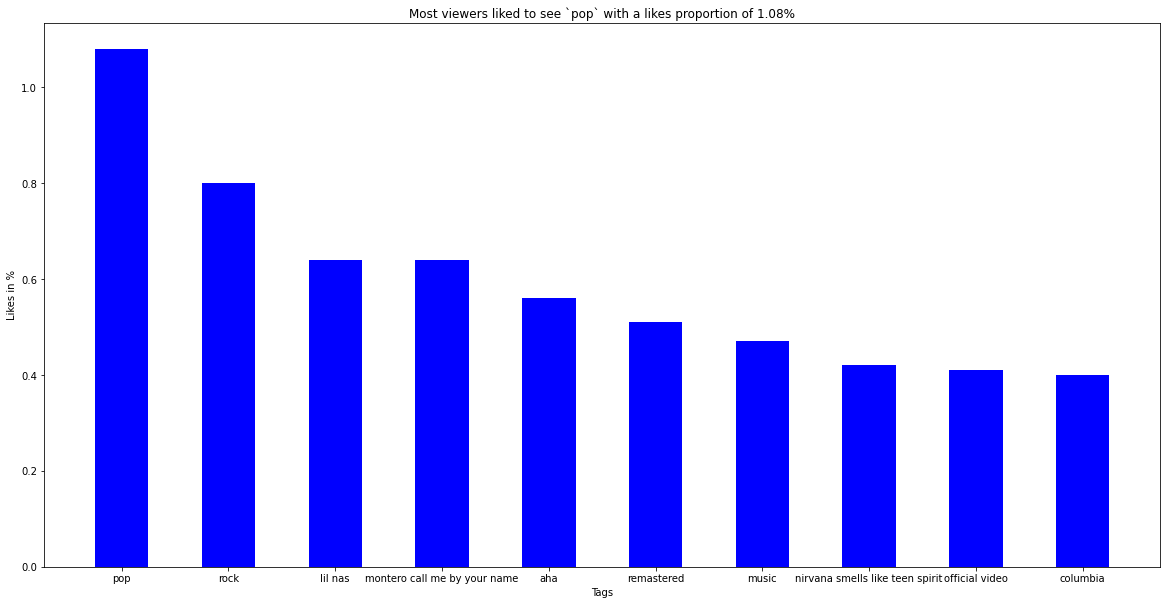

In [92]:
tag_list = []
tag_likes = []
total_likes = 0
max_likes = 0
max_likes_tag = -1
tag_dict_likes = {}
tag_likes_dist = {}
for idx,tags_list in enumerate(yt_data['videoTags']):    
    if tags_list[0] != 'NA':
        for tag in tags_list:
            tag = removeAllSplChars(tag)
            tag = tag.lower()
            if tag in tag_dict_likes:
                tag_dict_likes[tag] = tag_dict_likes[tag]+yt_data['videoLikes'][idx]
            else:
                tag_dict_likes[tag] = yt_data['videoLikes'][idx]
            total_likes = total_likes + yt_data['videoLikes'][idx]
#print(tag_dict_likes)
for tag in tag_dict_likes:
    tag_likes_dist[tag] = round((tag_dict_likes[tag]/total_likes)*100, 2)
    if max_likes < tag_likes_dist[tag]:
        max_likes = tag_likes_dist[tag]
        max_likes_tag = tag
tag_list = list(tag_dict_likes.keys())
tag_likes = list(tag_dict_likes.values())
print(f'Most viewers liked to see `{max_likes_tag}` with a likes proportion of {max_likes}%')
sort_likes = sorted(tag_likes_dist.items(), key=lambda x: x[1], reverse=True)
tag_list,tag_likes = make_a_list(sort_likes)
plot_the_list(x_list=tag_list, y_list=tag_likes, bar_color='blue',x_label='Tags', y_label='Likes in %', graph_title=f'Most viewers liked to see `{max_likes_tag}` with a likes proportion of {max_likes}%')
#print(tag_list,tag_likes)

In [93]:
#Words and their usage

Most popular word is `pop` with a likes proportion of 0.05%
How many results you want in graph? 10


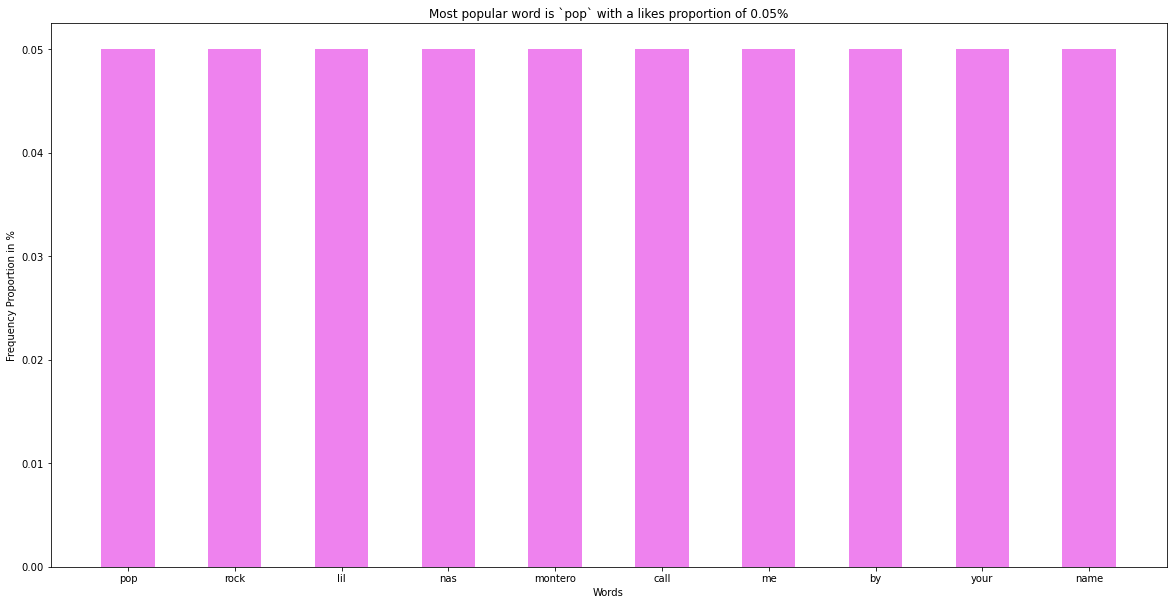

In [93]:
word_list = []
word_freq = []
word_dicti = {}
word_dist_dicti = {}
total_words = 0
max_occurence = 0
max_word = ''
for key in tag_list:
    sec_word_list = removeAllSplChars(key)
    sec_word_list = sec_word_list.lower()
    sec_word_list = sec_word_list.split(' ')
    for word in sec_word_list:
        if word in word_dicti:
            word_dicti[word] = word_dicti[word]+1
        else:
            word_dicti[word] = 1
        total_words=total_words+1
for word in word_dicti:
    word_dist_dicti[word] = round((word_dicti[word]/total_words),2)
    if max_occurence < word_dist_dicti[word]:
        max_occurence = word_dist_dicti[word]
        max_word = word
graph_title = f'Most popular word is `{max_word}` with a likes proportion of {max_occurence}%'
print(graph_title)
sort_words = sorted(word_dist_dicti.items(), key=lambda x: x[1], reverse=True)
word_list,word_freq = make_a_list(sort_words)
plot_the_list(x_list=word_list, y_list=word_freq, bar_color='violet',x_label='Words', y_label='Frequency Proportion in %', graph_title=graph_title)
#print(sort_words)

In [99]:
#Tags which attracted most number of views for the video

The tag which attracted most views is `rock` with a view proportion of 0.93%
How many results you want in graph? 10


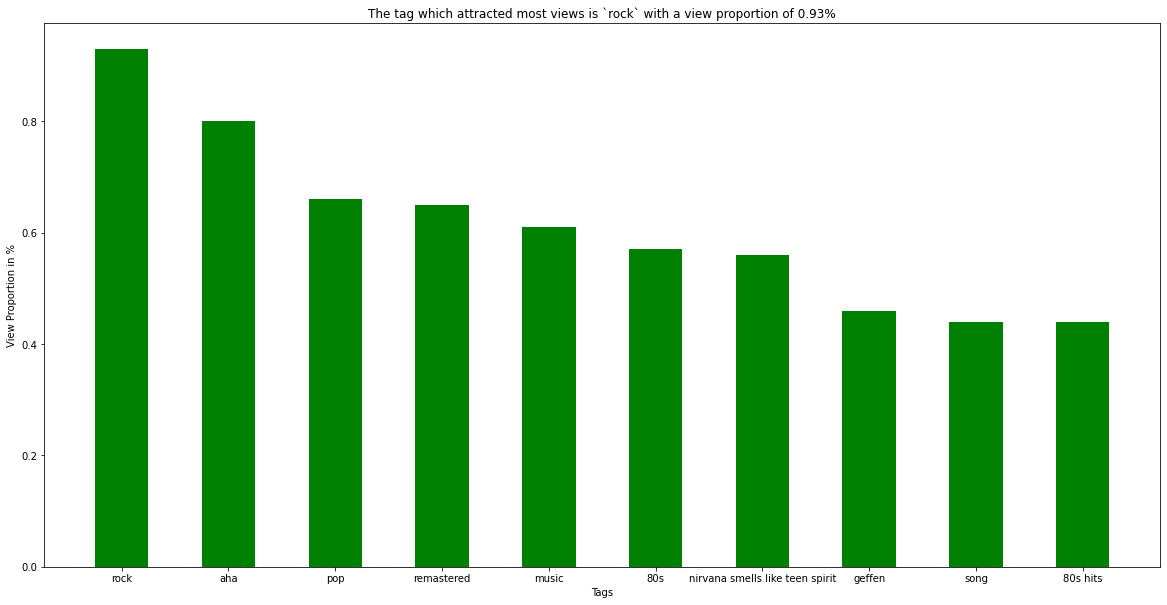

[('rock', 0.93), ('aha', 0.8), ('pop', 0.66), ('remastered', 0.65), ('music', 0.61), ('80s', 0.57), ('nirvana smells like teen spirit', 0.56), ('geffen', 0.46), ('song', 0.44), ('80s hits', 0.44), ('official video', 0.42), ('80s music', 0.41), ('take on me', 0.41), ('nirvana', 0.4), ('smells like teen spirit nirvana', 0.4), ('kurt cobain', 0.4), ('krist novoselic', 0.4), ('dave grohl', 0.4), ('dave grohl nirvana', 0.4), ('smells like teen spirit remastered', 0.4), ('smells like teen spirit remastered video', 0.4), ('nirvana remastered', 0.4), ('nirvana remastered videos', 0.4), ('kurt cobain nirvana', 0.4), ('smells like teen spirit nirvana official music video', 0.4), ('nirvana music video', 0.4), ('nirvana official music video hd', 0.4), ('nirvana hd', 0.4), ('nevermind', 0.4), ("80's", 0.39), ('aha band', 0.39), ('take on me take on me', 0.39), ('take on me lyrics', 0.39), ('take on me aha', 0.39), ('take on me deadpool 2 scene', 0.39), ('80s music hits', 0.39), ('best songs 80s', 0

In [94]:
tag_list = []
tag_views = []
total_views = 0
max_views = 0
max_views_tag = ''
tag_dict_views = {}
tag_views_dist = {}
for idx,tags_list in enumerate(yt_data['videoTags']):    
    if tags_list[0] != 'NA':
        for tag in tags_list:
            tag = removeAllSplChars(tag)
            tag = tag.lower()
            if tag in tag_dict_views:
                #tag = removeAllSplChars(tag)
                tag_dict_views[tag] = tag_dict_views[tag]+yt_data['videoViews'][idx]
            else:
                tag_dict_views[tag] = yt_data['videoViews'][idx]
            total_views = total_views+yt_data['videoViews'][idx]
for tag in tag_dict_views:
    tag_views_dist[tag] = round((tag_dict_views[tag]/total_views)*100, 2)
    if max_views < tag_views_dist[tag]:
        max_views = tag_views_dist[tag]
        max_views_tag=tag
tag_list = list(tag_dict_views.keys())
tag_views = list(tag_dict_views.values())
graph_title = f'The tag which attracted most views is `{max_views_tag}` with a view proportion of {max_views}%'
print(graph_title)
sort_views = sorted(tag_views_dist.items(), key=lambda x: x[1], reverse=True)
tag_list,tag_views = make_a_list(sort_views)
plot_the_list(x_list=tag_list, y_list=tag_views, bar_color='green',x_label='Tags', y_label='View Proportion in %', graph_title=graph_title)
print(sort_views)

In [54]:
#Tags which invited maximum engagement from viewers by the way of comments

The topic which attracted most engagement from viewers is `holiday` with a view proportion of 0.54%
How many results you want in graph? 10


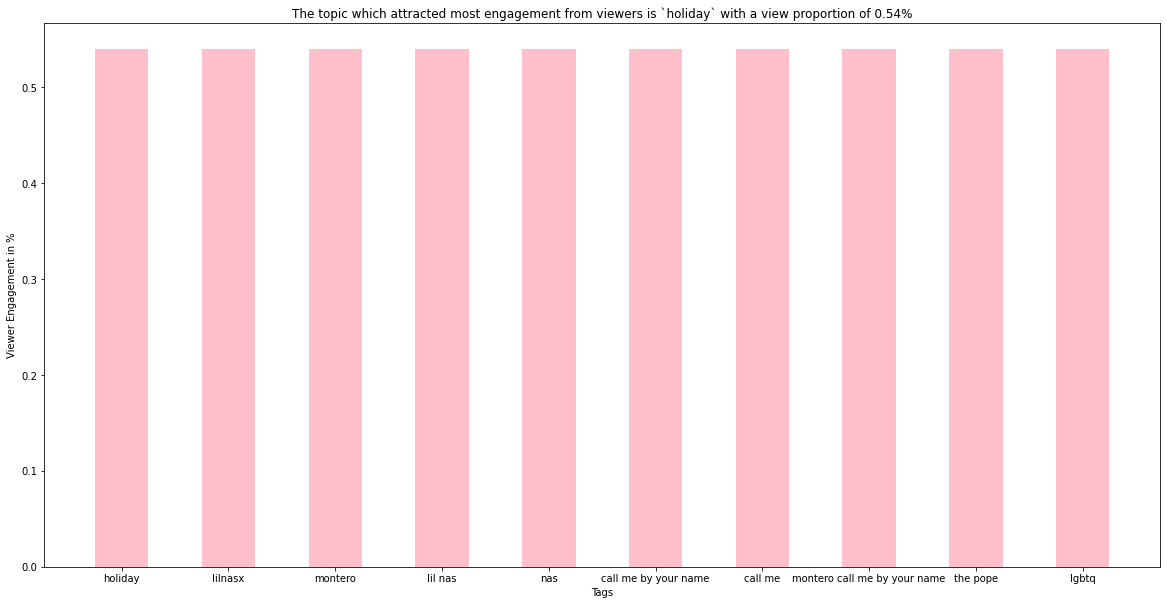

[('holiday', 0.54), ('lilnasx', 0.54), ('montero', 0.54), ('lil nas', 0.54), ('nas', 0.54), ('call me by your name', 0.54), ('call me', 0.54), ('montero call me by your name', 0.54), ('the pope', 0.54), ('lgbtq', 0.54), ('old town road', 0.54), ('rodeo', 0.54), ('pannini', 0.54), ('call me when you want', 0.54), ('call me when you need me', 0.54), ('lil nas montero', 0.54), ('lil nas call me by your name', 0.54), ('viral tiktok', 0.54), ('lil nas new song', 0.54), ('lil was new video', 0.54), ('montero (call me by your name)', 0.54), ('nirvana smells like teen spirit', 0.28), ('nirvana', 0.25), ('smells like teen spirit nirvana', 0.25), ('krist novoselic', 0.25), ('dave grohl', 0.25), ('dave grohl nirvana', 0.25), ('smells like teen spirit remastered', 0.25), ('smells like teen spirit remastered video', 0.25), ('nirvana remastered', 0.25), ('nirvana remastered videos', 0.25), ('kurt cobain nirvana', 0.25), ('smells like teen spirit nirvana official music video', 0.25), ('nirvana music 

In [95]:
tag_list = []
tag_comments = []
total_comments = 0
max_comments = 0
max_comments_tag = ''
tag_dict_comments = {}
tag_comments_dist = {}
for idx,tags_list in enumerate(yt_data['videoTags']):    
    if tags_list[0] != 'NA':
        for tag in tags_list:
            if tag in tag_dict_comments:
                tag_dict_comments[tag.lower()] = tag_dict_comments[tag]+yt_data['videoComments'][idx]
            else:
                tag_dict_comments[tag.lower()] = yt_data['videoComments'][idx]
            total_comments = total_comments+yt_data['videoComments'][idx]
for tag in tag_dict_comments:
    tag_comments_dist[tag.lower()] = round((tag_dict_comments[tag.lower()]/total_comments)*100, 2)
    if max_comments < tag_comments_dist[tag.lower()]:
        max_comments = tag_comments_dist[tag.lower()]
        max_comments_tag = tag.lower()
tag_list = list(tag_dict_comments.keys())
tag_comments = list(tag_dict_comments.values())
graph_title = f'The topic which attracted most engagement from viewers is `{max_comments_tag}` with a view proportion of {max_comments}%'
print(graph_title)
sort_comments = sorted(tag_comments_dist.items(), key=lambda x: x[1], reverse=True)
tag_list,tag_comments = make_a_list(sort_comments)
plot_the_list(x_list=tag_list, y_list=tag_comments, bar_color='pink',x_label='Tags', y_label='Viewer Engagement in %', graph_title=graph_title, graph_width=0.5)
print(sort_comments)

In [38]:
#Most views from which language video

The language which attracted most views is `en` with a view proportion of 75.75%
How many results you want in graph? 10


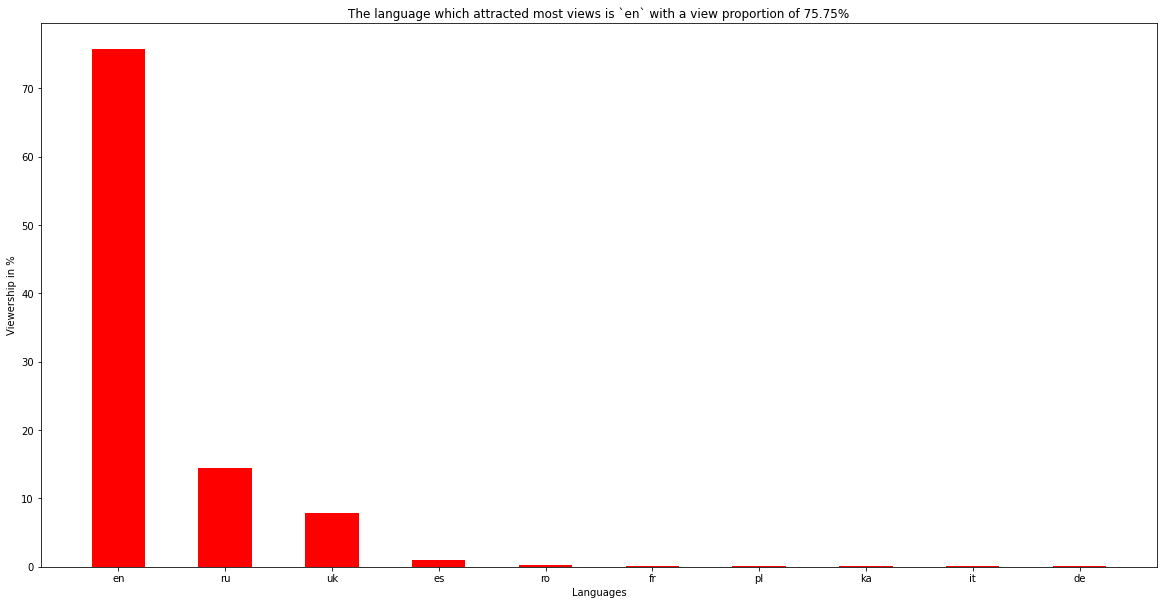

[('en', 75.75), ('ru', 14.42), ('uk', 7.84), ('es', 0.98), ('ro', 0.2), ('fr', 0.19), ('pl', 0.17), ('ka', 0.12), ('it', 0.09), ('de', 0.07), ('tr', 0.05), ('pt', 0.03), ('id', 0.02), ('ur', 0.02), ('bn', 0.02), ('bs', 0.0), ('az', 0.0), ('sv', 0.0), ('zx', 0.0), ('hy', 0.0), ('fi', 0.0), ('ms', 0.0), ('kk', 0.0), ('cs', 0.0), ('so', 0.0), ('tl', 0.0), ('ar', 0.0), ('ky', 0.0), ('sr', 0.0), ('lt', 0.0), ('gu', 0.0), ('sl', 0.0), ('el', 0.0), ('no', 0.0), ('bg', 0.0), ('vi', 0.0), ('uz', 0.0), ('un', 0.0), ('sq', 0.0), ('nl', 0.0), ('ja', 0.0)]


In [96]:
lang_list = []
lang_views = []
total_views = 0
max_views = 0
max_views_lang = ''
lang_dict_views = {}
lang_views_dist = {}
for idx,lang in enumerate(yt_data['videoLanguage']):
    if lang != 'NA':
        if lang in lang_dict_views:
            lang_dict_views[lang] = lang_dict_views[lang]+yt_data['videoViews'][idx]
        else:
            lang_dict_views[lang] = yt_data['videoViews'][idx]
        total_views = total_views+yt_data['videoViews'][idx]
for lang in lang_dict_views:
    lang_views_dist[lang] = round((lang_dict_views[lang]/total_views)*100, 2)
    if max_views < lang_views_dist[lang]:
        max_views = lang_views_dist[lang]
        max_views_lang=lang
lang_list = list(lang_dict_views.keys())
lang_views = list(lang_dict_views.values())
graph_title=f'The language which attracted most views is `{max_views_lang}` with a view proportion of {max_views}%'
print(graph_title)
sort_views = sorted(lang_views_dist.items(), key=lambda x: x[1], reverse=True)
lang_list,lang_views = make_a_list(sort_views)
plot_the_list(x_list=lang_list, y_list=lang_views, bar_color='red',x_label='Languages', y_label='Viewership in %', graph_title=graph_title)
print(sort_views)

In [1]:
#Most number of videos are from which country?

The videos originated from UA the most with a proportion of 46.8%.
How many results you want in graph? 10


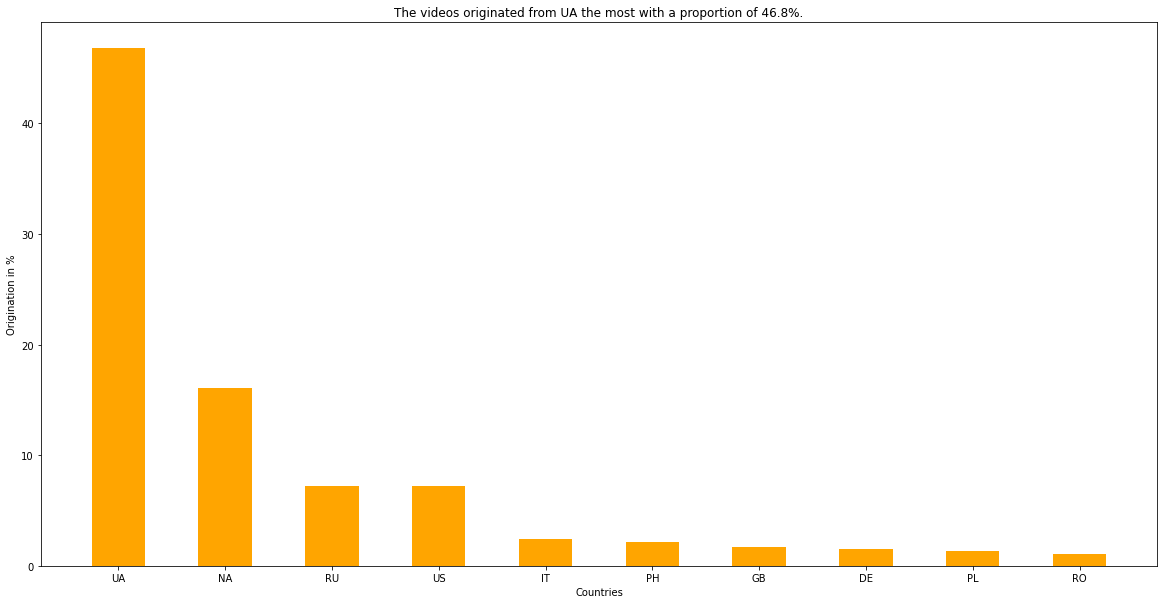

[('UA', 46.8), ('NA', 16.1), ('RU', 7.24), ('US', 7.24), ('IT', 2.44), ('PH', 2.16), ('GB', 1.74), ('DE', 1.55), ('PL', 1.3), ('RO', 1.1), ('PE', 1.07), ('FR', 0.94), ('IN', 0.8), ('RS', 0.75), ('BR', 0.72), ('AZ', 0.62), ('ES', 0.54), ('IL', 0.53), ('CA', 0.51), ('MX', 0.51), ('LT', 0.48), ('TR', 0.45), ('ID', 0.4), ('CZ', 0.39), ('AU', 0.25), ('KZ', 0.21), ('BE', 0.19), ('PK', 0.18), ('PT', 0.17), ('VN', 0.16), ('SE', 0.14), ('AT', 0.14), ('BY', 0.14), ('SK', 0.12), ('CH', 0.12), ('AE', 0.1), ('NL', 0.1), ('DK', 0.09), ('MY', 0.09), ('BG', 0.09), ('LV', 0.09), ('ZW', 0.08), ('HK', 0.07), ('CO', 0.06), ('GE', 0.06), ('SI', 0.06), ('IS', 0.06), ('NO', 0.06), ('GR', 0.06), ('NG', 0.05), ('CL', 0.04), ('SN', 0.04), ('HU', 0.04), ('CY', 0.04), ('KW', 0.03), ('AM', 0.03), ('TN', 0.03), ('AR', 0.03), ('JP', 0.03), ('AL', 0.03), ('CN', 0.03), ('ZA', 0.02), ('MA', 0.02), ('SG', 0.02), ('QA', 0.02), ('BA', 0.02), ('TH', 0.02), ('HR', 0.02), ('DZ', 0.01), ('HN', 0.01), ('GT', 0.01), ('IE', 0.01

In [97]:
channelid_cnt = {}
for idx in yt_data.index:
    if yt_data['channelId'][idx] in channelid_cnt:
        channelid_cnt[yt_data['channelId'][idx]] = channelid_cnt[yt_data['channelId'][idx]] + yt_data['count'][idx]
    else:
        channelid_cnt[yt_data['channelId'][idx]] = yt_data['count'][idx]
#print(channelid_cnt)
channel_cntry = {}
channel_list = yt_channel_data['channelIds'].tolist()
total_cntry = 0
max_cntry_dist = 0
max_cntry = ''
for channelID in channelid_cnt:
    if channelID in channel_list:
        c_index = channel_list.index(channelID)
        #print(yt_channel_data['channelCountry'][c_index])
        if yt_channel_data['channelCountry'][c_index] in channel_cntry:
            channel_cntry[yt_channel_data['channelCountry'][c_index]] = channel_cntry[yt_channel_data['channelCountry'][c_index]]+channelid_cnt[channelID]
        else:
            channel_cntry[yt_channel_data['channelCountry'][c_index]] = channelid_cnt[channelID]
        total_cntry = total_cntry+channelid_cnt[channelID]
#print(channel_cntry)
for cntry in channel_cntry:
    channel_cntry[cntry] = round((channel_cntry[cntry]/total_cntry)*100, 2)
    if max_cntry_dist < channel_cntry[cntry]:
        max_cntry_dist = channel_cntry[cntry]
        max_cntry=cntry
sort_cntry = sorted(channel_cntry.items(), key=lambda x: x[1], reverse=True)
graph_title = f'The videos originated from {max_cntry} the most with a proportion of {max_cntry_dist}%.'
print(graph_title)
cntry_list,video_dist = make_a_list(sort_cntry)
plot_the_list(x_list=cntry_list, y_list=video_dist, bar_color='orange',x_label='Countries', y_label='Origination in %', graph_title=graph_title)
print(sort_cntry)

In [30]:
print('Dataframe Describe:',yt_data.describe())
print('Dataframe Shape:',yt_data.shape)

Dataframe Describe:              count     videoTime    videoViews    videoLikes  videoComments
count  10000.00000  1.000000e+04  1.000000e+04  1.000000e+04   10000.000000
mean      40.20510  1.153484e+04  9.857817e+05  1.341871e+04    1407.341600
std      159.80433  4.591343e+05  2.167589e+07  9.251810e+04    5278.229344
min       17.00000  0.000000e+00  0.000000e+00  0.000000e+00       0.000000
25%       21.00000  7.100000e+01  6.575000e+01  1.000000e+00       0.000000
50%       28.00000  3.940000e+02  9.001000e+03  2.240000e+02      27.000000
75%       41.00000  9.912500e+02  1.543888e+05  9.171500e+03     902.250000
max    15423.00000  3.559096e+07  1.306202e+09  6.675428e+06  305293.000000
Dataframe Shape: (10000, 13)


In [31]:
print('Dataframe Describe:',yt_channel_data.describe())
print('Dataframe Shape:',yt_channel_data.shape)

Dataframe Describe:         subscribers  channelViews     videoCount
count  2.970000e+03  2.970000e+03    2970.000000
mean   4.770922e+05  2.100295e+08    4359.113131
std    2.044999e+06  9.968486e+08   20035.588654
min    0.000000e+00  0.000000e+00       0.000000
25%    1.390000e+03  1.431388e+05      80.000000
50%    1.700000e+04  2.580481e+06     268.000000
75%    2.027500e+05  4.011854e+07    1063.750000
max    5.330000e+07  2.071943e+10  385437.000000
Dataframe Shape: (2970, 8)


In [31]:
#Time given for each tag/topic

In [52]:
time_type = input('Stats needed in days or hours or minutes seconds?')
div = 1
suff = 's'
if time_type.lower() == 'days':
    div = 86400
    suff = 'day/s'
elif time_type.lower() == 'years':
    div = 31536000
    suff = 'year/s'
elif time_type.lower() == 'hours':
    div = 3600
    suff = 'hour/s'
elif time_type.lower() == 'minutes':
    div = 60
    suff = 'min/s'
else:
    div = 1
tag_list = []
tag_times = []
total_time = 0
max_time = 0
max_time_tag = ''
tag_dict_times = {}
for idx,tags_list in enumerate(yt_data['videoTags']):    
    if tags_list[0] != 'NA':
        for tag in tags_list:
            tag = removeAllSplChars(tag)
            tag = tag.lower()
            if tag in tag_dict_times:
                tag_dict_times[tag] = tag_dict_times[tag]+yt_data['videoTime'][idx]
            else:
                tag_dict_times[tag] = yt_data['videoTime'][idx]
            total_time = total_time+yt_data['videoTime'][idx]
for tag in tag_dict_times:
    tag_dict_times[tag] = round(tag_dict_times[tag]/div,1)
for tag in tag_dict_times:
    if max_time < tag_dict_times[tag]:
        max_time = tag_dict_times[tag]
        max_time_tag=tag
#tag_list = list(tag_dict_views.keys())
#tag_views = list(tag_dict_views.values())
graph_title = f'Time worth `{tag_dict_times[max_time_tag]}` {suff} was given on the topic `{max_time_tag}`'
print(graph_title)
sort_times = sorted(tag_dict_times.items(), key=lambda x: x[1], reverse=True)
tag_list,tag_times = make_a_list(sort_times)
plot_the_list(x_list=tag_list, y_list=tag_times, bar_color='green',x_label='Tags', y_label=f'Time in {suff}', graph_title=graph_title)
print(sort_times)

Stats needed in days or hours or minutes seconds?days
Time worth `670.7` day/s was given on the topic `новости`
How many results you want in graph? 7
[('новости', 670.7), ('новости украины', 551.2), ('украина', 420.2), ('порошенко', 416.4), ('новости сегодня', 414.1), ('украина 24 онлайн', 412.6), ('україна 24', 412.4), ('україна 24 прямий ефір', 412.2), ('украина 24 прямой эфир', 412.2), ('новини онлайн', 412.0), ('новини політики', 412.0), ('україна 24 онлайн', 412.0), ('полуев', 412.0), ('гордон голованов', 412.0), ('украина 24 смотреть', 412.0), ('украина 24 видео', 412.0), ('новости украины сегодня', 412.0), ('новости сейчас', 412.0), ('украина 24 гордон', 411.9), ('україна 24 трансляція онлайн', 411.9), ('україна 24 наживо', 411.9), ('новини онлайн прямий ефір', 411.9), ('україна 24 новини', 411.9), ('україна 24 прямий єфір', 411.9), ('голованов украина 24', 411.9), ('зеленский ютуб', 411.9), ('марафон', 411.9), ('breaking news', 366.4), ('news', 362.9), ('rt', 241.0), ('world ne

In [55]:
print('For this one, we assume that viewers have watched complete videos.')
time_type = input('Stats needed in years, days or hours or minutes seconds?')
div = 1
suff = 's'
if time_type.lower() == 'days':
    div = 86400
    suff = 'day/s'
elif time_type.lower() == 'years':
    div = 31536000
    suff = 'year/s'
elif time_type.lower() == 'hours':
    div = 3600
    suff = 'hour/s'
elif time_type.lower() == 'minutes':
    div = 60
    suff = 'min/s'
else:
    div = 1
tag_wtime_dict = {}
tag_list = list(tag_dict_views.keys())
for tag in tag_list:
    if tag_dict_views[tag] != 0:
        tag_wtime_dict[tag] = (tag_dict_views[tag]*tag_dict_times[tag])
for tag in tag_wtime_dict:
    tag_wtime_dict[tag] = round(tag_wtime_dict[tag]/div,1)
#print(tag_wtime_dict) 
sort_wtimes = sorted(tag_wtime_dict.items(), key=lambda x: x[1], reverse=True)
# People have watched this topic for:
graph_title = f'Topic/Tag `{sort_wtimes[0][0]}` attracted a watch time of `{sort_wtimes[0][1]} {suff}`'
print(graph_title)
tag_list,tag_wtimes = make_a_list(sort_wtimes)
plot_the_list(x_list=tag_list, y_list=tag_wtimes, bar_color='green',x_label='Tags', y_label=f'Watch time in {suff}', graph_title=graph_title)
#print(sort_wtimes)

For this one, we assume that viewers have watched complete videos.
Stats needed in years, days or hours or minutes seconds?years
Topic/Tag `news` attracted a watch time of `16575.9 year/s`
How many results you want in graph? 7


In [24]:
#Temporal Evolution of fb and YouTube

In [32]:
min_month,min_year,max_month,max_year = get_date_range_from(data,'date')

Dataset ranges from 9/2021 to 4/2022


In [33]:
yt_min_month,yt_min_year,yt_max_month,yt_max_year = get_date_range_from(yt_data,'videoPublishedAt')

Dataset ranges from 5/2010 to 7/2022


In [118]:
TE_min_year = 0
TE_max_year = 0
TE_min_month = 0
TE_max_year = 0
if yt_min_year < min_year:
    TE_min_year = yt_min_year
    TE_min_month = yt_min_month
elif yt_min_year > min_year:
    TE_min_year = min_year
    TE_min_month = min_month
else:
    TE_min_year = min_year
    if min_month < yt_min_month:
        TE_min_month = min_month
    else:
        TE_min_month = yt_min_month
if yt_max_year > max_year:
    TE_max_year = yt_max_year
    TE_max_month = yt_max_month
elif yt_max_year < max_year:
    TE_max_year = max_year
    TE_max_month = max_month
else:
    TE_max_year = max_year
    if max_month > yt_max_month:
        TE_max_month = max_month
    else:
        TE_max_month = yt_max_month
print(f'So for temporal evolution, we take the range {TE_min_year}/{TE_min_month} to {TE_max_year}/{TE_max_month}')

So for temporal evolution, we take the range 2014/7 to 2022/4


In [34]:
TE_min_month, TE_min_year, TE_max_month, TE_max_year = min_month,min_year,max_month,max_year
print(f'So for temporal evolution, we take the range {TE_min_year}/{TE_min_month} to {TE_max_year}/{TE_max_month}')

So for temporal evolution, we take the range 2021/9 to 2022/4


In [120]:
date_range_week = get_date_dictionary_week(TE_min_year,TE_min_month,TE_max_year,TE_max_month)
print(date_range_week)

{'2021-9-07': 0, '2021-9-15': 0, '2021-9-23': 0, '2021-9-31': 0, '2021-10-07': 0, '2021-10-15': 0, '2021-10-23': 0, '2021-10-31': 0, '2021-11-07': 0, '2021-11-15': 0, '2021-11-23': 0, '2021-11-31': 0, '2021-12-07': 0, '2021-12-15': 0, '2021-12-23': 0, '2021-12-31': 0, '2022-1-07': 0, '2022-1-15': 0, '2022-1-23': 0, '2022-1-31': 0, '2022-2-07': 0, '2022-2-15': 0, '2022-2-23': 0, '2022-2-31': 0, '2022-3-07': 0, '2022-3-15': 0, '2022-3-23': 0, '2022-3-31': 0, '2022-4-07': 0, '2022-4-15': 0, '2022-4-23': 0, '2022-4-31': 0}


In [35]:
fb_date = get_date_dictionary(TE_min_month, TE_min_year, TE_max_month, TE_max_year, data, 'date',True)

{'2021-9': 4.34, '2021-10': 5.21, '2021-11': 5.49, '2021-12': 6.29, '2022-1': 7.04, '2022-2': 18.45, '2022-3': 38.47, '2022-4': 14.7}


In [36]:
yt_date = get_date_dictionary(TE_min_month,TE_min_year,TE_max_month,TE_max_year, yt_data,'videoPublishedAt',True)

2015-9 not in dictionary
2018-3 not in dictionary
2021-7 not in dictionary
2014-7 not in dictionary
2021-1 not in dictionary
2021-2 not in dictionary
2019-2 not in dictionary
2021-8 not in dictionary
2020-4 not in dictionary
2021-1 not in dictionary
2018-10 not in dictionary
2017-12 not in dictionary
2019-2 not in dictionary
2020-11 not in dictionary
2021-7 not in dictionary
2019-5 not in dictionary
2018-8 not in dictionary
2014-2 not in dictionary
2021-6 not in dictionary
2021-7 not in dictionary
2022-7 not in dictionary
2019-2 not in dictionary
2021-2 not in dictionary
2012-7 not in dictionary
2021-2 not in dictionary
2015-12 not in dictionary
2021-6 not in dictionary
2019-9 not in dictionary
2018-4 not in dictionary
2017-9 not in dictionary
2020-6 not in dictionary
2018-2 not in dictionary
2016-2 not in dictionary
2020-11 not in dictionary
2021-5 not in dictionary
2014-8 not in dictionary
2016-7 not in dictionary
2019-10 not in dictionary
2021-8 not in dictionary
2021-8 not in dicti

In [37]:
print(len(yt_date))
FBshare_time = fb_date.keys()
FBshare_perc = fb_date.values()
YTshare_time = yt_date.keys()
YTshare_perc = yt_date.values()
fig = plt.figure(figsize = (200, 100))
plt.plot(FBshare_time,FBshare_perc,color = 'blue', label = 'Facebook')
plt.plot(FBshare_time,YTshare_perc,color = 'red', label = 'YouTube')
plt.xlabel('Dates')
plt.ylabel('Share in %')
plt.title('Temporal Evolution')
plt.legend(['Facebook','YouTube'])
plt.show()

8


In [69]:
#Temporal Evolution of fb and YouTube - Week-wise

In [88]:
print(list(fb_date.keys()))

['21-9', '21-10', '21-11', '21-12', '22-1', '22-2', '22-3', '22-4']


In [38]:
date_list = list(fb_date.keys())
fb_week = get_week_dictionary(date_list, get_date_dictionary_week(TE_min_year,TE_min_month,TE_max_year,TE_max_month), data, 'date',True)
print(fb_week)

{'2021-9-07': 1.01, '2021-9-15': 1.07, '2021-9-23': 1.19, '2021-9-31': 1.07, '2021-10-07': 1.07, '2021-10-15': 1.34, '2021-10-23': 1.38, '2021-10-31': 1.42, '2021-11-07': 1.29, '2021-11-15': 1.38, '2021-11-23': 1.46, '2021-11-31': 1.35, '2021-12-07': 1.46, '2021-12-15': 1.62, '2021-12-23': 1.65, '2021-12-31': 1.55, '2022-1-07': 1.21, '2022-1-15': 1.6, '2022-1-23': 1.92, '2022-1-31': 2.31, '2022-2-07': 1.89, '2022-2-15': 2.13, '2022-2-23': 2.39, '2022-2-31': 12.04, '2022-3-07': 14.31, '2022-3-15': 9.48, '2022-3-23': 8.11, '2022-3-31': 6.56, '2022-4-07': 5.14, '2022-4-15': 5.33, '2022-4-23': 4.22, '2022-4-31': 0.0}


In [39]:
yt_week = get_week_dictionary(date_list,get_date_dictionary_week(TE_min_year,TE_min_month,TE_max_year,TE_max_month), yt_data, 'videoPublishedAt',True)
print(yt_week)

{'2021-9-07': 0.59, '2021-9-15': 0.88, '2021-9-23': 0.59, '2021-9-31': 0.74, '2021-10-07': 0.74, '2021-10-15': 1.18, '2021-10-23': 1.03, '2021-10-31': 0.74, '2021-11-07': 1.47, '2021-11-15': 0.29, '2021-11-23': 1.03, '2021-11-31': 1.62, '2021-12-07': 0.88, '2021-12-15': 1.47, '2021-12-23': 1.18, '2021-12-31': 1.62, '2022-1-07': 1.18, '2022-1-15': 1.03, '2022-1-23': 1.92, '2022-1-31': 1.77, '2022-2-07': 1.77, '2022-2-15': 1.33, '2022-2-23': 2.95, '2022-2-31': 16.22, '2022-3-07': 16.96, '2022-3-15': 10.91, '2022-3-23': 7.08, '2022-3-31': 6.19, '2022-4-07': 6.34, '2022-4-15': 4.72, '2022-4-23': 3.54, '2022-4-31': 0.0}


In [40]:
FBshare_time = fb_week.keys()
FBshare_perc = fb_week.values()
YTshare_time = yt_week.keys()
YTshare_perc = yt_week.values()
fig = plt.figure(figsize = (500, 100))
ax = plt.subplot()
plt.plot(FBshare_time,FBshare_perc,color = 'blue', label = 'Facebook')
plt.plot(FBshare_time,YTshare_perc,color = 'red', label = 'YouTube')
plt.xlabel('Dates')
plt.ylabel('Share in %')
plt.title('Temporal Evolution weekwise')
plt.legend(['Facebook','YouTube'])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [75]:
#Finding sentiments, toxicity, insult and threat probability for YouTube video titles

In [42]:
data_pt = int(input('1: videoTitle \n2: videoDescription? '))
if data_pt == 1:
    data_pt = 'videoTitle'
else:
    data_pt = 'videoDescription'

1: videoTitle 
2: videoDescription? 1


In [53]:
# tox_list = []
# ins_list = []
# thr_list = []
senti_list = []
yt_title_list = []
pp_title_list = []
yt_vid_list = []
preprocessed_title = ''
yt_data_len = len(yt_data)
count = 1
senti_analyzer = SentimentIntensityAnalyzer()
for idx in yt_data.index:
    if yt_data[data_pt][idx] != 'NA':
        print(f'{count}/{yt_data_len} processing...',end="")
        preprocessed_title = get_preprocessed_text(yt_data[data_pt][idx])
#         ins_val,tox_val,thr_val = get_perspective_from(preprocessed_title)
#         ins_list.append(ins_val)
#         tox_list.append(tox_val)
#         thr_list.append(thr_val)
        pp_title_list.append(preprocessed_title)
        yt_title_list.append(yt_data[data_pt][idx])
        yt_vid_list.append(yt_data['videoIds'][idx])
        senti_val = senti_analyzer.polarity_scores(preprocessed_title)['compound']
        senti_list.append(senti_val)
        print('processed!')
        count = count+1
yt_videoTitle_data = pd.DataFrame({'videoIds':yt_vid_list,
                                  data_pt:yt_title_list,
                                   'Preprocessed Title': pp_title_list,
                                   'sentiment':senti_list})
yt_videoTitle_data

1/1000 processing...processed!
2/1000 processing...processed!
3/1000 processing...processed!
4/1000 processing...processed!
5/1000 processing...processed!
6/1000 processing...processed!
7/1000 processing...processed!
8/1000 processing...processed!
9/1000 processing...processed!
10/1000 processing...processed!
11/1000 processing...processed!
12/1000 processing...processed!
13/1000 processing...processed!
14/1000 processing...processed!
15/1000 processing...processed!
16/1000 processing...processed!
17/1000 processing...processed!
18/1000 processing...processed!
19/1000 processing...processed!
20/1000 processing...processed!
21/1000 processing...processed!
22/1000 processing...processed!
23/1000 processing...processed!
24/1000 processing...processed!
25/1000 processing...processed!
26/1000 processing...processed!
27/1000 processing...processed!
28/1000 processing...processed!
29/1000 processing...processed!
30/1000 processing...processed!
31/1000 processing...processed!
32/1000 processin

252/1000 processing...processed!
253/1000 processing...processed!
254/1000 processing...processed!
255/1000 processing...processed!
256/1000 processing...processed!
257/1000 processing...processed!
258/1000 processing...processed!
259/1000 processing...processed!
260/1000 processing...processed!
261/1000 processing...processed!
262/1000 processing...processed!
263/1000 processing...processed!
264/1000 processing...processed!
265/1000 processing...processed!
266/1000 processing...processed!
267/1000 processing...processed!
268/1000 processing...processed!
269/1000 processing...processed!
270/1000 processing...processed!
271/1000 processing...processed!
272/1000 processing...processed!
273/1000 processing...processed!
274/1000 processing...processed!
275/1000 processing...processed!
276/1000 processing...processed!
277/1000 processing...processed!
278/1000 processing...processed!
279/1000 processing...processed!
280/1000 processing...processed!
281/1000 processing...processed!
282/1000 p

500/1000 processing...processed!
501/1000 processing...processed!
502/1000 processing...processed!
503/1000 processing...processed!
504/1000 processing...processed!
505/1000 processing...processed!
506/1000 processing...processed!
507/1000 processing...processed!
508/1000 processing...processed!
509/1000 processing...processed!
510/1000 processing...processed!
511/1000 processing...processed!
512/1000 processing...processed!
513/1000 processing...processed!
514/1000 processing...processed!
515/1000 processing...processed!
516/1000 processing...processed!
517/1000 processing...processed!
518/1000 processing...processed!
519/1000 processing...processed!
520/1000 processing...processed!
521/1000 processing...processed!
522/1000 processing...processed!
523/1000 processing...processed!
524/1000 processing...processed!
525/1000 processing...processed!
526/1000 processing...processed!
527/1000 processing...processed!
528/1000 processing...processed!
529/1000 processing...processed!
530/1000 p

748/1000 processing...processed!
749/1000 processing...processed!
750/1000 processing...processed!
751/1000 processing...processed!
752/1000 processing...processed!
753/1000 processing...processed!


videoIds                                         videoTitle  \
0    saEpkcVi1d4  Pink Floyd - Hey Hey Rise Up (feat. Andriy Khl...   
1    JrMiSQAGOS4  Why is Ukraine the West's Fault? Featuring Joh...   
2    hSJKaeMHSOU  Noneho Ukraine igiye kwihorera igitwaro cya ki...   
3    6ohMKNthCqA  Ucraniana fala a verdade sobre Zelensky na TV ...   
4    JaLerV_NtMs  EARN FREE 100 GCASH MONEY|ARAW ARAW MAY PERA K...   
..           ...                                                ...   
748  vo3_ttw8YFs  Що там знову в них з тими ПОДУШКАМИ в Моївці? ...   
749  FdPXgbfX_lM    Ukraine : et si Vladimir Poutine avait raison ?   
750  RibAQHeDia8  Winter On Fire: Ukraine's Fight for Freedom | ...   
751  hw3cBOYafSU  Новая стратегическая ситуация в мире. Путински...   
752  xYstAdc8iuI  PUTIN YATEYE UKRAINE ASHAKA NATO IMURUSHA AMAY...   

                                    Preprocessed Title  sentiment  
0    pink floyd hey hey rise up feat andriy khlyvny...     0.0000  
1    why is ukraine the wests fault featuring john ...    -0.4019  
2    Now Ukraine is going to revenge a nuclear weap...    -0.7906  
3    Ukrainian tells the truth about Zelensky on TV...    -0.0772  
4    EARN FREE GCASH MONEY DAY DAY YOU HAVE MONEY I...     0.8429  
..                                                 ...        ...  
748  that there again them with those pillows in Mo...     0.0000  
749            Ukraine and if Vladimir Putin was right     0.0000  
750  winter on fire ukraines fight for freedom trai...     0.0516  
751  The new strategic situation in Mire Putinski r...     0.1280  
752  Putin caused Natraine and Natato was very tact...    -0.7351  

[753 rows x 4 columns]

In [ ]:
tox_list = []
ins_list = []
thr_list = []
for idx in yt_videoTitle_data.index:
    if yt_videoTitle_data[data_pt][idx] != 'NA':
        preprocessed_title = yt_videoTitle_data['Preprocessed Title'][idx]
        ins_val,tox_val,thr_val = get_perspective_from(preprocessed_title)
        ins_list.append(ins_val)
        tox_list.append(tox_val)
        thr_list.append(thr_val)
yt_videoTitle_data.insert(4,'toxicity',tox_list)
yt_videoTitle_data.insert(5,'insult',ins_list)
yt_videoTitle_data.insert(6,'threat',thr_list)

In [42]:
yt_videoTitle_data.describe()

sentiment   toxicity     insult     threat
count  85.000000  85.000000  85.000000  85.000000
mean   -0.064082   0.123654   0.128986   0.260533
std     0.397510   0.259779   0.257767   0.331873
min    -0.790600  -1.000000  -1.000000  -1.000000
25%    -0.381800   0.039598   0.064234   0.100098
50%     0.000000   0.117941   0.127731   0.235518
75%     0.000000   0.229521   0.196123   0.448219
max     0.890800   0.680955   0.660731   0.971279

In [39]:
#Moral Foundation for video titles

In [67]:
title_df = pd.DataFrame(pp_title_list)
videoid_list = list(yt_videoTitle_data['videoIds'])
num_docs = len(title_df)

DICT_TYPE = 'emfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = 'vice-virtue'
out_df = score_docs(title_df,DICT_TYPE,PROB_MAP,SCORE_METHOD,OUT_METRICS,num_docs)
out_df

Processed: 753 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:05 Time:  0:00:05


care.virtue  fairness.virtue  loyalty.virtue  authority.virtue  \
0       0.000000         0.016667        0.085714          0.000000   
1       0.000000         0.000000        0.000000          0.000000   
2       0.000000         0.017730        0.017787          0.018229   
3       0.070588         0.171717        0.000000          0.125000   
4       0.036000         0.058388        0.050996          0.049555   
..           ...              ...             ...               ...   
748     0.000000         0.000000        0.000000          0.000000   
749     0.153992         0.169381        0.159278          0.142132   
750     0.047945         0.078199        0.048729          0.070652   
751     0.023632         0.051458        0.040766          0.044725   
752     0.000000         0.000000        0.000000          0.000000   

     sanctity.virtue  care.vice  fairness.vice  loyalty.vice  authority.vice  \
0           0.083333   0.045833       0.037594      0.069343        0.083912   
1           0.000000   0.000000       0.000000      0.000000        0.000000   
2           0.017812   0.202901       0.111311      0.108277        0.159452   
3           0.231579   0.000000       0.000000      0.120000        0.000000   
4           0.036608   0.058233       0.100417      0.016657        0.025843   
..               ...        ...            ...           ...             ...   
748         0.000000   0.000000       0.000000      0.000000        0.000000   
749         0.000000   0.000000       0.000000      0.000000        0.000000   
750         0.077128   0.103077       0.060855      0.082298        0.095016   
751         0.022447   0.084149       0.030090      0.056316        0.036202   
752         0.014184   0.173927       0.105502      0.148137        0.115877   

     sanctity.vice  moral_nonmoral_ratio     f_var  
0         0.030702              0.285714  0.001150  
1         0.000000              0.000000  0.000000  
2         0.116633              2.000000  0.005142  
3         0.000000              0.166667  0.007383  
4         0.031508              1.600000  0.000552  
..             ...                   ...       ...  
748       0.000000              0.000000  0.000000  
749       0.127660              0.333333  0.006406  
750       0.052727              0.400000  0.000365  
751       0.053759              1.500000  0.000340  
752       0.098846              0.600000  0.004848  

[753 rows x 12 columns]

In [69]:
out_df.insert(1,'videoIds',videoid_list)
out_df

care.virtue     videoIds  fairness.virtue  loyalty.virtue  \
0       0.000000  saEpkcVi1d4         0.016667        0.085714   
1       0.000000  JrMiSQAGOS4         0.000000        0.000000   
2       0.000000  hSJKaeMHSOU         0.017730        0.017787   
3       0.070588  6ohMKNthCqA         0.171717        0.000000   
4       0.036000  JaLerV_NtMs         0.058388        0.050996   
..           ...          ...              ...             ...   
748     0.000000  vo3_ttw8YFs         0.000000        0.000000   
749     0.153992  FdPXgbfX_lM         0.169381        0.159278   
750     0.047945  RibAQHeDia8         0.078199        0.048729   
751     0.023632  hw3cBOYafSU         0.051458        0.040766   
752     0.000000  xYstAdc8iuI         0.000000        0.000000   

     authority.virtue  sanctity.virtue  care.vice  fairness.vice  \
0            0.000000         0.083333   0.045833       0.037594   
1            0.000000         0.000000   0.000000       0.000000   
2            0.018229         0.017812   0.202901       0.111311   
3            0.125000         0.231579   0.000000       0.000000   
4            0.049555         0.036608   0.058233       0.100417   
..                ...              ...        ...            ...   
748          0.000000         0.000000   0.000000       0.000000   
749          0.142132         0.000000   0.000000       0.000000   
750          0.070652         0.077128   0.103077       0.060855   
751          0.044725         0.022447   0.084149       0.030090   
752          0.000000         0.014184   0.173927       0.105502   

     loyalty.vice  authority.vice  sanctity.vice  moral_nonmoral_ratio  \
0        0.069343        0.083912       0.030702              0.285714   
1        0.000000        0.000000       0.000000              0.000000   
2        0.108277        0.159452       0.116633              2.000000   
3        0.120000        0.000000       0.000000              0.166667   
4        0.016657        0.025843       0.031508              1.600000   
..            ...             ...            ...                   ...   
748      0.000000        0.000000       0.000000              0.000000   
749      0.000000        0.000000       0.127660              0.333333   
750      0.082298        0.095016       0.052727              0.400000   
751      0.056316        0.036202       0.053759              1.500000   
752      0.148137        0.115877       0.098846              0.600000   

        f_var  
0    0.001150  
1    0.000000  
2    0.005142  
3    0.007383  
4    0.000552  
..        ...  
748  0.000000  
749  0.006406  
750  0.000365  
751  0.000340  
752  0.004848  

[753 rows x 13 columns]

In [64]:
select_moral_thres = int(input('1: Relative or 2: regular? '))
avg_mimr = 0
if select_moral_thres == 1:
    avg_mimr = out_df['moral_nonmoral_ratio'].mean()
else:
    avg_mimr = -1
print(f'Threshold: {avg_mimr}')

1: Relative or 2: regular? 1
Threshold: 0.8034282598027613


In [123]:
#Morality distribution within video categories

In [70]:
video_id_list = list(yt_data['videoIds'])
video_cat_pos,video_cat_pos_dist,video_cat_neg,video_cat_neg_dist = get_video_category_stats(videoid_list,
                                                                                             out_df,
                                                                                             'moral_nonmoral_ratio',avg_mimr)
print(video_cat_pos_dist)
print(video_cat_neg_dist)

{'Film & Animation': 0.18, 'Howto & Style': 0.54, 'People & Blogs': 7.73, 'News & Politics': 16.37, 'Science & Technology': 0.36, 'Travel & Events': 0.54, 'Comedy': 0.72, 'Music': 3.24, 'Education': 0.72, 'Entertainment': 1.98, 'Nonprofits & Activism': 0.54}
{'Music': 8.09, 'Education': 2.34, 'News & Politics': 33.27, 'Entertainment': 5.22, 'People & Blogs': 13.31, 'Film & Animation': 0.54, 'Travel & Events': 0.9, 'Autos & Vehicles': 0.18, 'Nonprofits & Activism': 1.26, 'Comedy': 1.26, 'Howto & Style': 0.54, 'Sports': 0.18}


In [53]:
video_cat_immoral = {}
video_cat_immoral_dist = {}
sort_cat_immoral = {}
video_cat_moral = {}
video_cat_moral_dist = {}
sort_cat_moral = {}
graph_title = ''
y_label = ''
for idx in out_df.index:
    if yt_data['videoCategory'][idx] != 'NA':
        if out_df['moral_nonmoral_ratio'][idx] < avg_mimr:
            if yt_data['videoCategory'][idx] in video_cat_immoral:
                video_cat_immoral[yt_data['videoCategory'][idx]] = video_cat_immoral[yt_data['videoCategory'][idx]]+1
            else:
                video_cat_immoral[yt_data['videoCategory'][idx]] = 1
        else:
            if yt_data['videoCategory'][idx] in video_cat_moral:
                video_cat_moral[yt_data['videoCategory'][idx]] = video_cat_moral[yt_data['videoCategory'][idx]]+1
            else:
                video_cat_moral[yt_data['videoCategory'][idx]] = 1
perc_flag = input('Need stats in percentage? 1: Yes or 2: No')
if perc_flag == '1':
    for cat in video_cat_immoral:
        video_cat_immoral_dist[cat] = round((video_cat_immoral[cat]/nums_video)*100,2)
    for cat in video_cat_moral:
        video_cat_moral_dist[cat] = round((video_cat_moral[cat]/nums_video)*100,2)
    sort_cat_immoral = sorted(video_cat_immoral_dist.items(), key=lambda x: x[1], reverse=True)
    sort_cat_moral = sorted(video_cat_moral_dist.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_cat_immoral[0]}% was most immoral category and\n{sort_cat_moral[0]}% most moral.'
    y_label = 'Num of videos in %'
else:
    sort_cat_immoral = sorted(video_cat_immoral.items(), key=lambda x: x[1], reverse=True)
    sort_cat_moral = sorted(video_cat_moral.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_cat_immoral[0]} was most immoral category and\n{sort_cat_moral[0]} most moral.'
    y_label = 'Num of videos'
print(graph_title)
print(f'Immorality: {sort_cat_immoral} Morality: {sort_cat_moral}')
cat_list,cat_count = make_a_list(sort_cat_immoral)
plot_the_list(x_list=cat_list, y_list=cat_count, bar_color='red',x_label='Video Categories', y_label=y_label, graph_title=graph_title)
cat_list,cat_count = make_a_list(sort_cat_moral)
plot_the_list(x_list=cat_list, y_list=cat_count, bar_color='blue',x_label='Video Categories', y_label=y_label, graph_title=graph_title)

Need stats in percentage? 1: Yes or 2: No2
Out of 100 most shared videos, 15 were unavailable and ('News & Politics', 23) was most immoral category and
('News & Politics', 9) most moral.
Immorality: [('News & Politics', 23), ('Music', 13), ('Entertainment', 6), ('Education', 4), ('People & Blogs', 2), ('Film & Animation', 2)] Morality: [('News & Politics', 9), ('Music', 6), ('People & Blogs', 3), ('Howto & Style', 2), ('Travel & Events', 2), ('Film & Animation', 1), ('Science & Technology', 1), ('Comedy', 1), ('Education', 1)]
How many results you want in graph? 10
How many results you want in graph? 10


In [122]:
#Morality distribution within video topics

In [54]:
video_top_immoral = {}
video_top_immoral_dist = {}
sort_top_immoral = {}
video_top_moral = {}
video_top_moral_dist = {}
sort_top_moral = {}
graph_title = ''
for idx in out_df.index:
    if out_df['moral_nonmoral_ratio'][idx] < avg_mimr:
        if len(yt_data['videoTopics'][idx]) > 0 and yt_data['videoTopics'][idx][0] != 'NA':
            for top in yt_data['videoTopics'][idx]:
                if top in video_top_immoral:
                    video_top_immoral[top] = video_top_immoral[top]+1
                else:
                    video_top_immoral[top] = 1
    else:
        if len(yt_data['videoTopics'][idx]) > 0 and yt_data['videoTopics'][idx][0] != 'NA':
            for top in yt_data['videoTopics'][idx]:
                if top in video_top_moral:
                    video_top_moral[top] = video_top_moral[top]+1
                else:
                    video_top_moral[top] = 1

perc_flag = input('Need stats in percentage? 1: Yes or 2: No')
if perc_flag == '1':
    for cat in video_top_immoral:
        video_top_immoral_dist[cat] = round((video_top_immoral[cat]/nums_video)*100,2)
    for cat in video_top_moral:
        video_top_moral_dist[cat] = round((video_top_moral[cat]/nums_video)*100,2)
    sort_top_immoral = sorted(video_top_immoral_dist.items(), key=lambda x: x[1], reverse=True)
    sort_top_moral = sorted(video_top_moral_dist.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_top_immoral[0]}% was most immoral category and\n{sort_top_moral[0]}% most moral.'
    y_label = 'Num of videos in %'
else:
    sort_top_immoral = sorted(video_top_immoral.items(), key=lambda x: x[1], reverse=True)
    sort_top_moral = sorted(video_top_moral.items(), key=lambda x: x[1], reverse=True)
    graph_title = f'Out of {nums_video} most shared videos, {len(unavailable_videoIds)} were unavailable and {sort_top_immoral[0]} was most immoral category and\n{sort_top_moral[0]} most moral.'
    y_label = 'Num of videos'
print(graph_title)
print(f'Immorality: {sort_top_immoral} Morality: {sort_top_moral}')
top_list,top_count = make_a_list(sort_top_immoral)                    
plot_the_list(x_list=top_list, y_list=top_count, bar_color='red',x_label='Video Topics', y_label=y_label, graph_title=graph_title)                    
top_list,top_count = make_a_list(sort_top_moral)                    
plot_the_list(x_list=top_list, y_list=top_count, bar_color='blue',x_label='Video Topics', y_label=y_label, graph_title=graph_title)                    

Need stats in percentage? 1: Yes or 2: No1
Out of 100 most shared videos, 15 were unavailable and ('Society', 34.0)% was most immoral category and
('Society', 12.0)% most moral.
Immorality: [('Society', 34.0), ('Politics', 23.0), ('Music', 12.0), ('Pop_music', 5.0), ('Religion', 4.0), ('Rock_music', 3.0), ('Television_program', 3.0), ('Independent_music', 2.0), ('Classical_music', 2.0), ('Military', 2.0), ('Electronic_music', 2.0), ('Christian_music', 1.0), ('Entertainment', 1.0), ('Film', 1.0), ('Association_football', 1.0), ('Sport', 1.0), ('Hip_hop_music', 1.0), ('Knowledge', 1.0)] Morality: [('Society', 12.0), ('Politics', 6.0), ('Music', 6.0), ('Lifestyle_(sociology)', 4.0), ('Pop_music', 3.0), ('Classical_music', 2.0), ('Film', 1.0), ('Technology', 1.0), ('Knowledge', 1.0), ('Christian_music', 1.0), ('Entertainment', 1.0), ('Television_program', 1.0), ('Vehicle', 1.0), ('Independent_music', 1.0)]
How many results you want in graph? 10
How many results you want in graph? 10


In [96]:
#Date distribution of moral/immorality

In [116]:
immoral_time_dict = get_date_range_dictionary(TE_min_month,TE_min_year,TE_max_month,TE_max_year)
moral_time_dict = get_date_range_dictionary(TE_min_month,TE_min_year,TE_max_month,TE_max_year)
for idx in out_df.index:
    if out_df['moral_nonmoral_ratio'][idx] < avg_mimr and yt_data['videoPublishedAt'][idx] != 'NA':
        vid_yr, vid_mnt, vid_day = get_year_from_str(yt_data['videoPublishedAt'][idx])
        date_str = f'{vid_yr}-{vid_mnt}'
        if date_str in immoral_time_dict:
            immoral_time_dict[date_str] = immoral_time_dict[date_str]+1
#         else:
#             immoral_time_dict[date_str] = 1
    elif out_df['moral_nonmoral_ratio'][idx] >= avg_mimr and yt_data['videoPublishedAt'][idx] != 'NA':
        vid_yr, vid_mnt,vid_day = get_year_from_str(yt_data['videoPublishedAt'][idx])
        date_str = f'{vid_yr}-{vid_mnt}'
        if date_str in moral_time_dict:
            moral_time_dict[date_str] = moral_time_dict[date_str]+1
#         else:
#             moral_time_dict[date_str] = 1
print(f'Moral content distribution: {immoral_time_dict},Immoral Content Distribution: {moral_time_dict}')
print(len(yt_date))
share_time = immoral_time_dict.keys()
moral_share = moral_time_dict.values()
immoral_share = immoral_time_dict.values()
fig = plt.figure(figsize = (200, 100))
plt.plot(share_time,moral_share,color = 'blue', label = 'Moral Content')
plt.plot(share_time,immoral_share,color = 'red', label = 'Immoral Content')
plt.xlabel('Dates')
plt.ylabel('Share')
plt.title('Evolution of moral and immoral content over time')
plt.legend(['Moral','Immoral'])
plt.show()

Moral content distribution: {'2021-9': 7, '2021-10': 5, '2021-11': 9, '2021-12': 8, '2022-1': 9, '2022-2': 56, '2022-3': 90, '2022-4': 28},Immoral Content Distribution: {'2021-9': 1, '2021-10': 6, '2021-11': 7, '2021-12': 7, '2022-1': 7, '2022-2': 26, '2022-3': 60, '2022-4': 24}
8


In [54]:
#Sentiment Polarity distribution among video categories

In [57]:
video_id_list = list(yt_data['videoIds'])

In [62]:
video_cat_pos,video_cat_pos_dist,video_cat_neg,video_cat_neg_dist = get_video_category_stats(video_id_list,
                                                                                             yt_videoTitle_data,
                                                                                             'sentiment',0)
print(video_cat_pos_dist)
print(video_cat_neg_dist)

{'Howto & Style': 0.62, 'Music': 3.71, 'News & Politics': 16.29, 'Entertainment': 3.3, 'Travel & Events': 0.41, 'Education': 0.62, 'People & Blogs': 7.84, 'Nonprofits & Activism': 0.82, 'Comedy': 0.41}
{'Education': 2.27, 'Film & Animation': 0.62, 'News & Politics': 37.53, 'People & Blogs': 13.2, 'Entertainment': 4.95, 'Music': 3.71, 'Howto & Style': 0.41, 'Nonprofits & Activism': 1.03, 'Comedy': 0.82, 'Science & Technology': 0.82, 'Sports': 0.21, 'Travel & Events': 0.21, 'Gaming': 0.21}


In [60]:
video_cat_pos = {}
video_cat_pos_dist = {}
video_cat_neg = {}
video_cat_neg_dist = {}
vc_dist = {}
total_vids = 0
for idx in yt_videoTitle_data.index:
    if yt_videoTitle_data['sentiment'][idx] > 0:
        video_ind = video_id_list.index(yt_videoTitle_data['videoIds'][idx])
        if yt_data['videoCategory'][video_ind] != 'NA':
            if yt_data['videoCategory'][video_ind] in video_cat_pos:
                video_cat_pos[yt_data['videoCategory'][video_ind]] = video_cat_pos[yt_data['videoCategory'][video_ind]] + 1
            else:
                video_cat_pos[yt_data['videoCategory'][video_ind]] = 1
            total_vids = total_vids+1
    elif  yt_videoTitle_data['sentiment'][idx] < 0:
        video_ind = video_id_list.index(yt_videoTitle_data['videoIds'][idx])
        if yt_data['videoCategory'][video_ind] != 'NA':
            if yt_data['videoCategory'][video_ind] in video_cat_neg:
                video_cat_neg[yt_data['videoCategory'][video_ind]] = video_cat_neg[yt_data['videoCategory'][video_ind]] + 1
            else:
                video_cat_neg[yt_data['videoCategory'][video_ind]] = 1
            total_vids = total_vids+1
for video_cat in video_cat_pos:
    video_cat_pos_dist[video_cat] = round((video_cat_pos[video_cat]/total_vids)*100,2)
for video_cat in video_cat_neg:
    video_cat_neg_dist[video_cat] = round((video_cat_neg[video_cat]/total_vids)*100,2)
print(video_cat_pos_dist)
print(video_cat_neg_dist)

{'Howto & Style': 0.62, 'Music': 3.71, 'News & Politics': 16.29, 'Entertainment': 3.3, 'Travel & Events': 0.41, 'Education': 0.62, 'People & Blogs': 7.84, 'Nonprofits & Activism': 0.82, 'Comedy': 0.41}
{'Education': 2.27, 'Film & Animation': 0.62, 'News & Politics': 37.53, 'People & Blogs': 13.2, 'Entertainment': 4.95, 'Music': 3.71, 'Howto & Style': 0.41, 'Nonprofits & Activism': 1.03, 'Comedy': 0.82, 'Science & Technology': 0.82, 'Sports': 0.21, 'Travel & Events': 0.21, 'Gaming': 0.21}


In [22]:
#Fetching video comments

In [59]:
vid_list = yt_data['videoIds'].tolist()

In [ ]:
json_comments = {}
for x in range(0,len(vid_list)):
    comments_from = requests.get(f'https://youtube.googleapis.com/youtube/v3/commentThreads?part=snippet&maxResults=100&videoId={vid_list[x]}&key={YT_API_KEY}')
        #time.sleep(7)
    #print(json.loads(comments_from.text))
    if 'error' not in json.loads(comments_from.text):
        print(json.loads(comments_from.text)['kind'])
        if len(json_comments) == 0:
            json_comments = json.loads(comments_from.text)
        else:
            json_comments_2 = json.loads(comments_from.text)
        json_comments['items'] = [*json_comments['items'],*json_comments_2['items']]
print(len(json_comments['items']))

In [ ]:
print(json_comments['items'])

In [ ]:
json_comments['items'][1]['snippet']